In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"anudeepdivi","key":"332e87256fa9dda71fe5572e44669633"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salikhussaini49/prediction-of-sepsis

Dataset URL: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis
License(s): CC-BY-NC-SA-4.0
 87% 65.0M/74.7M [00:01<00:00, 50.4MB/s]
100% 74.7M/74.7M [00:01<00:00, 48.3MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/prediction-of-sepsis.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("dataset extracted")

dataset extracted


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [ ]:
combined = pd.read_csv('/content/Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [ ]:
df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

In [ ]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [ ]:
patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [ ]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
EtCO2,100.000000
TroponinI,99.877881
Bilirubin_direct,99.850420
Fibrinogen,99.236917
Bilirubin_total,98.773372
Alkalinephos,98.540650
AST,98.504205
Lactate,96.565112
PTT,95.152459
SaO2,95.044387


In [ ]:
columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

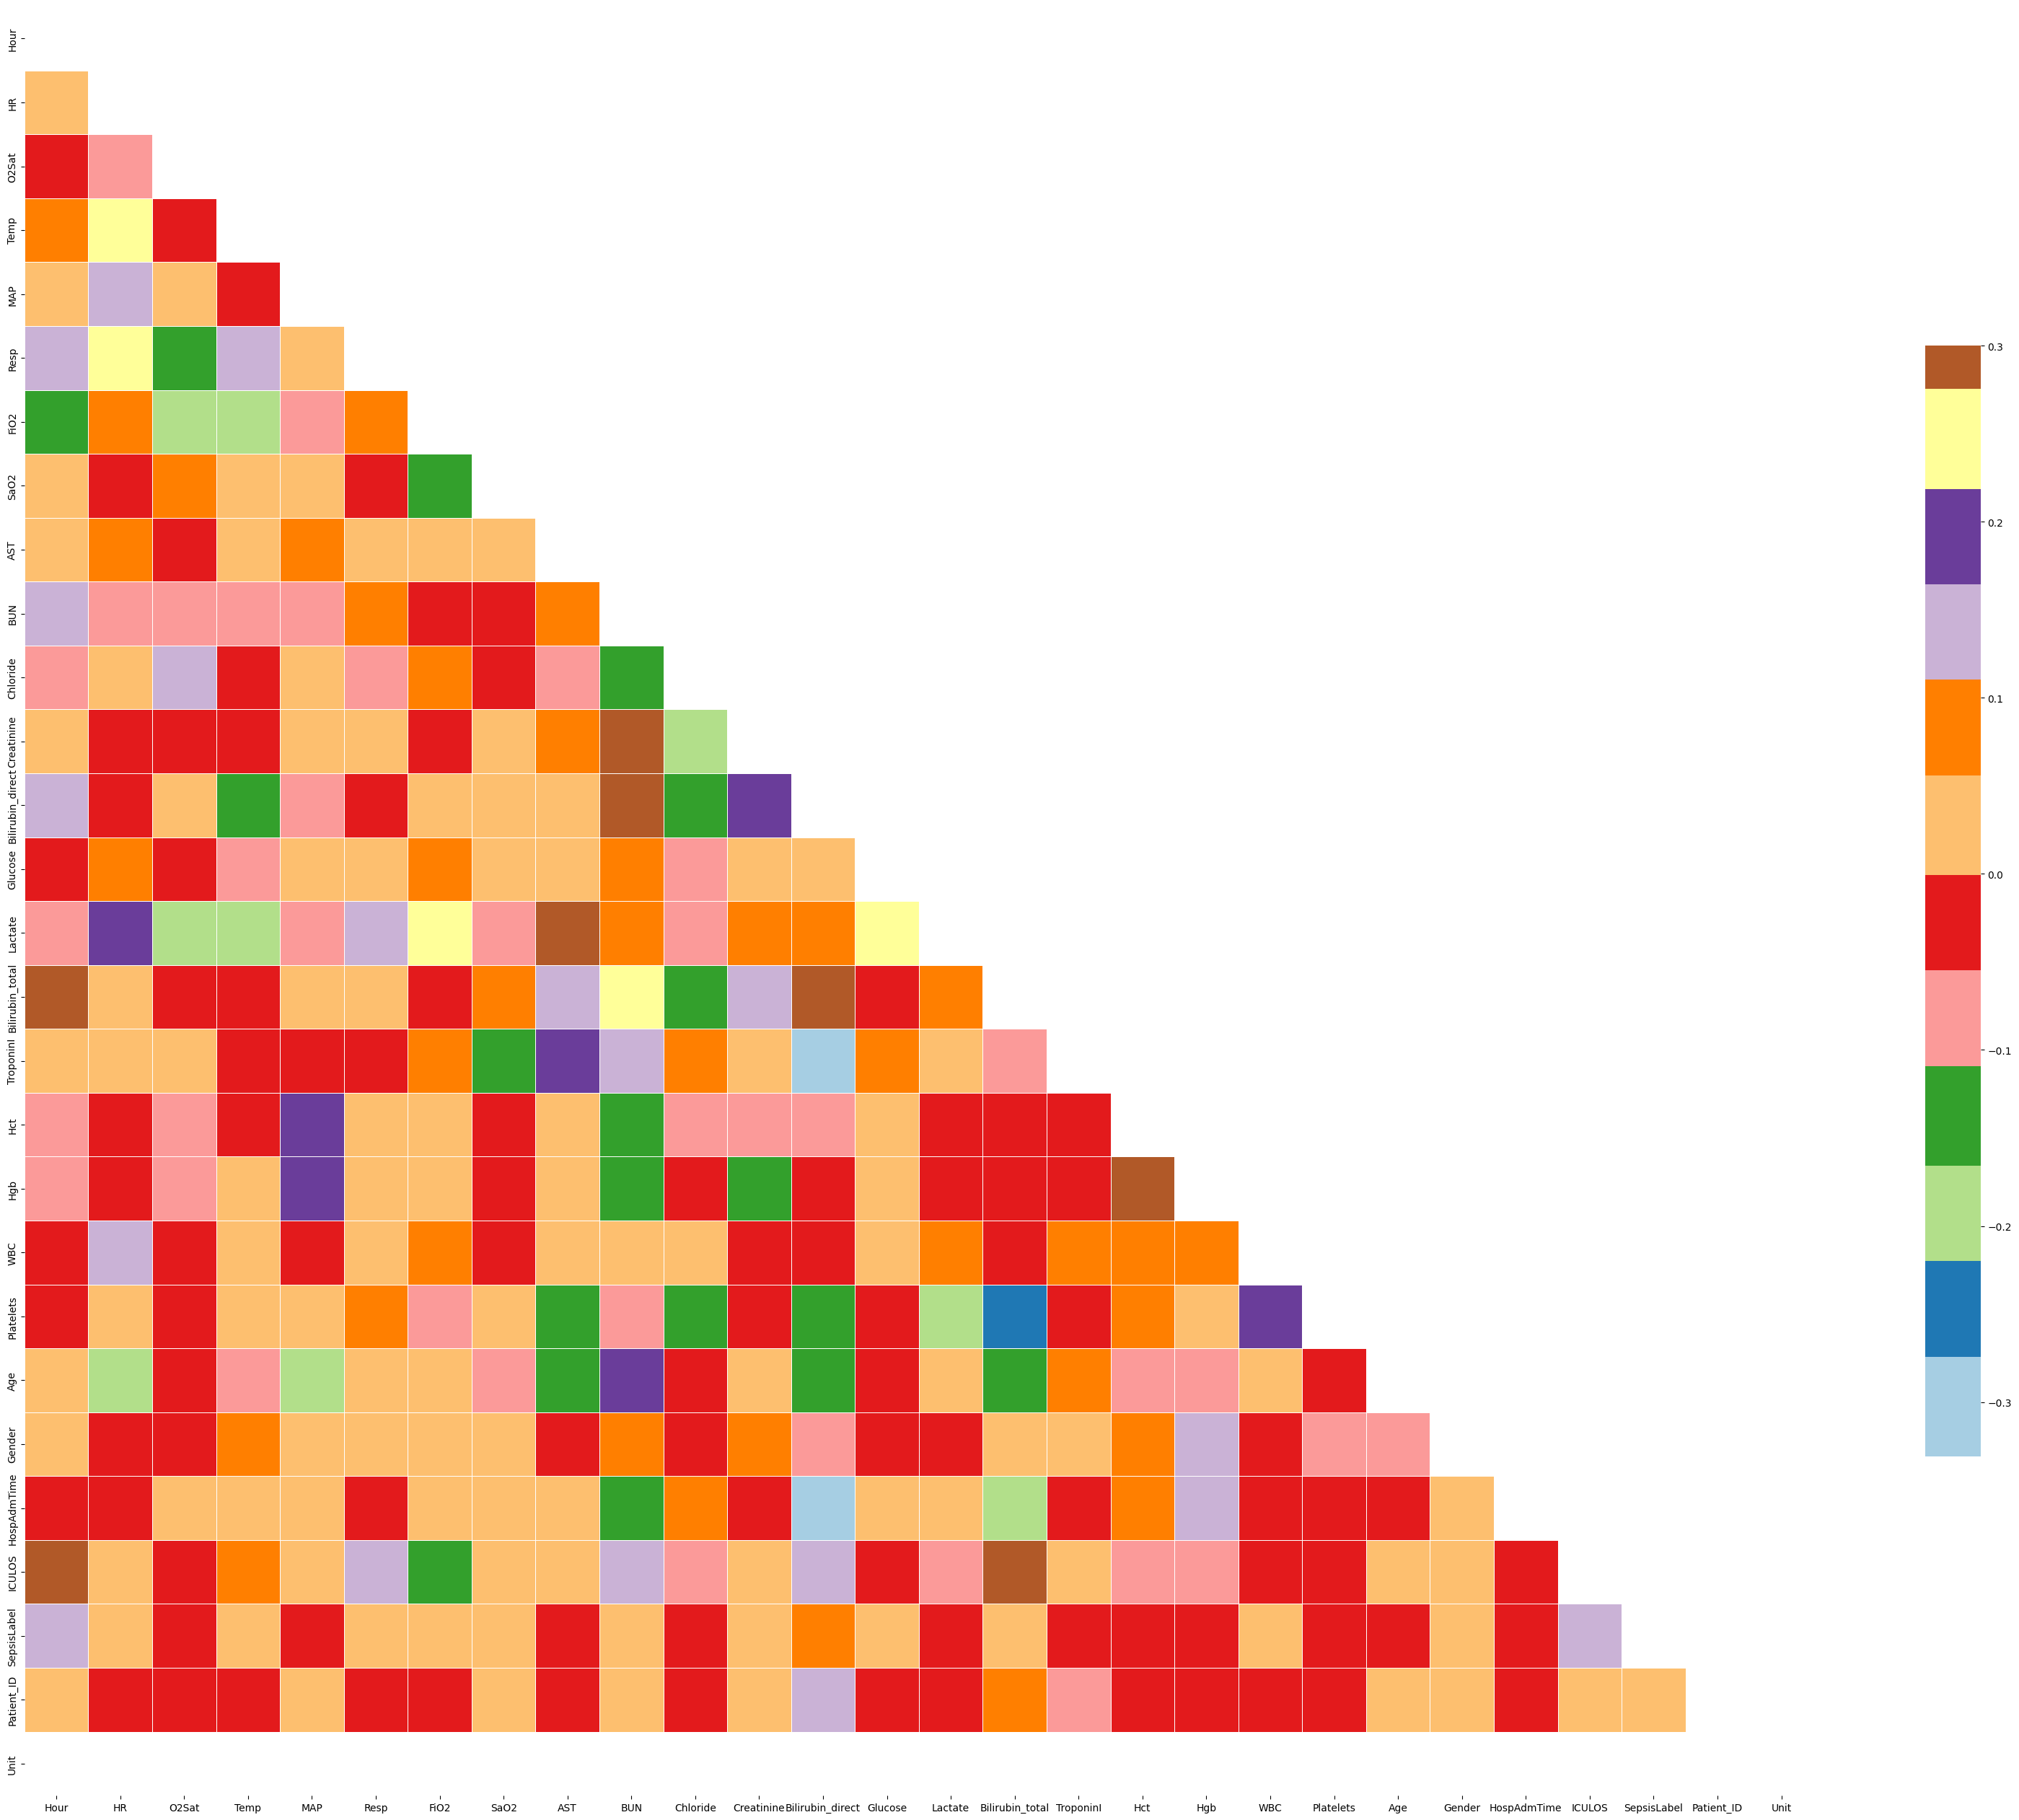

In [ ]:
corr_matrix(df_train_mod)

In [ ]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [ ]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

<ipython-input-16-630336680b91>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [ ]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                    
1          132940     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                    BUN  ...   Hgb  WBC  Platelets    Age  Gender  \
Patient_ID               ...                                        
1          132940  14.0  ...  12.5  5.7      317.0  83.14       0   
           132941  14.0  ...  12.5  5.7      317.0  83.14       0   
           132942  14.0  ...  12.5  5.7      317.0  83.14       0   
           132943  14.0  ...  12.5  5.7      317.0  83.14       0   
           132944  14.0  ...  12.5  5.7      317.0  83.14       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,97.357934
Bilirubin_direct,96.256841
Bilirubin_total,66.949754
AST,66.435590
SaO2,57.282891
Lactate,55.997418
Unit,48.868346
FiO2,36.195592
WBC,1.511994
Platelets,1.394810


In [ ]:
null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [ ]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)


In [ ]:
def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [ ]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  df[col] = df[col].fillna(df[col].mean())  # Replace NaN with the mean of the column
  df[col] = df[col].replace([np.inf, -np.inf], df[col].mean())  # Replace inf with the mean of the column
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col])
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot')
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot')
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001)
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')

O2Sat
actual plot


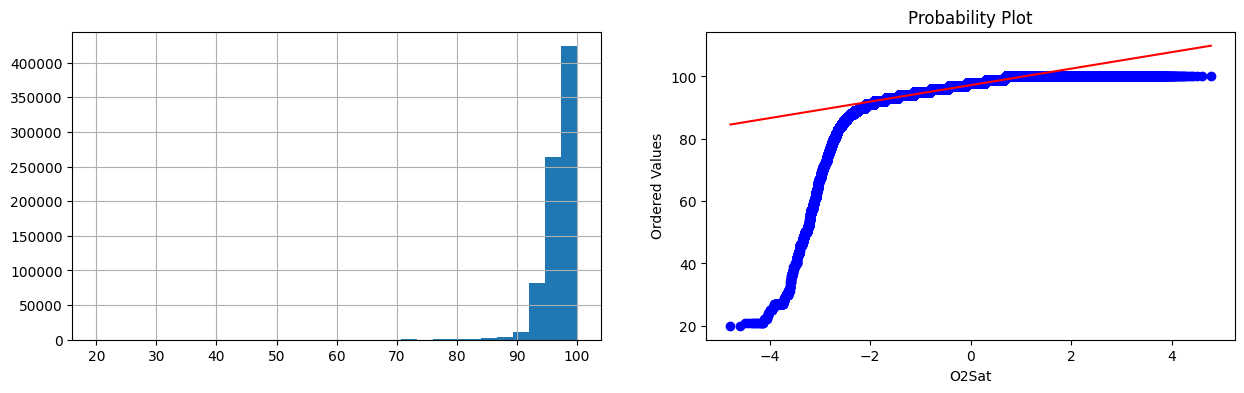

yeojohnson plot


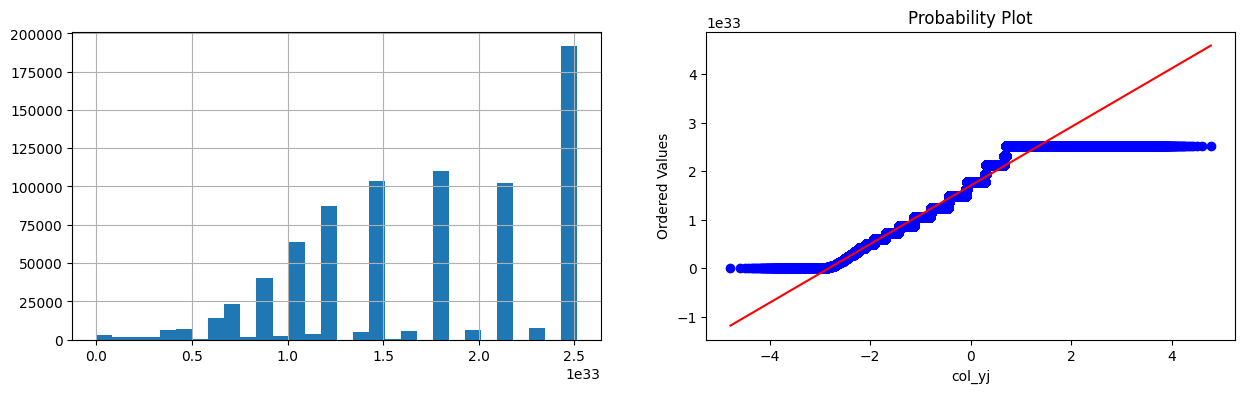

**1/1.5 plot


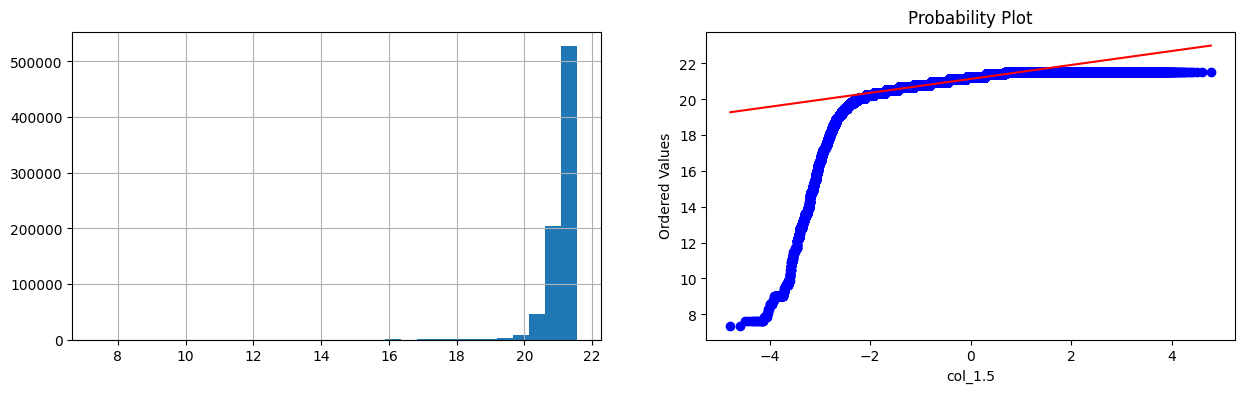

**.5 plot


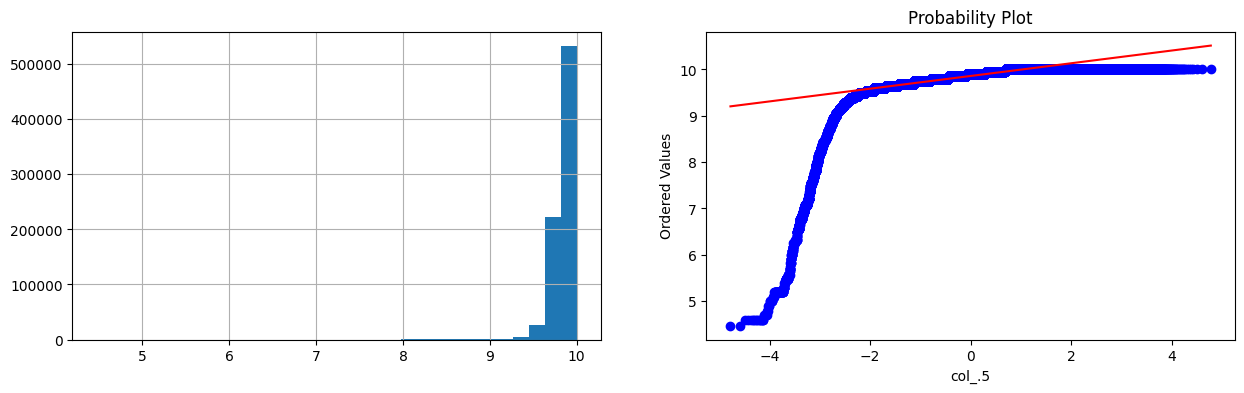

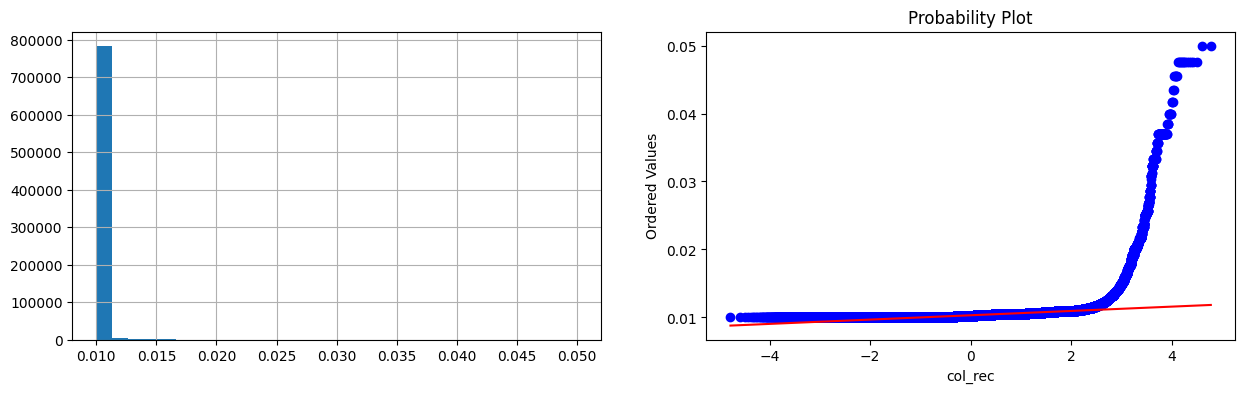

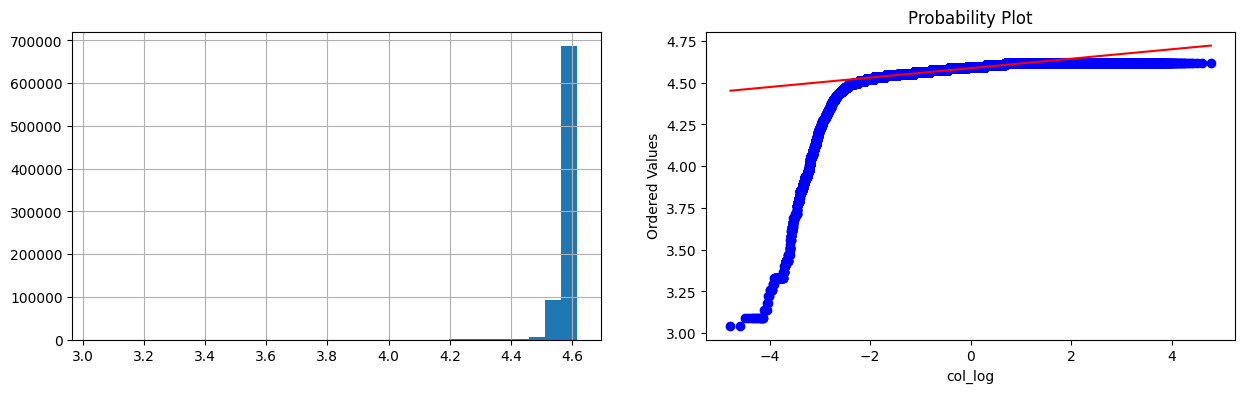

Temp
actual plot


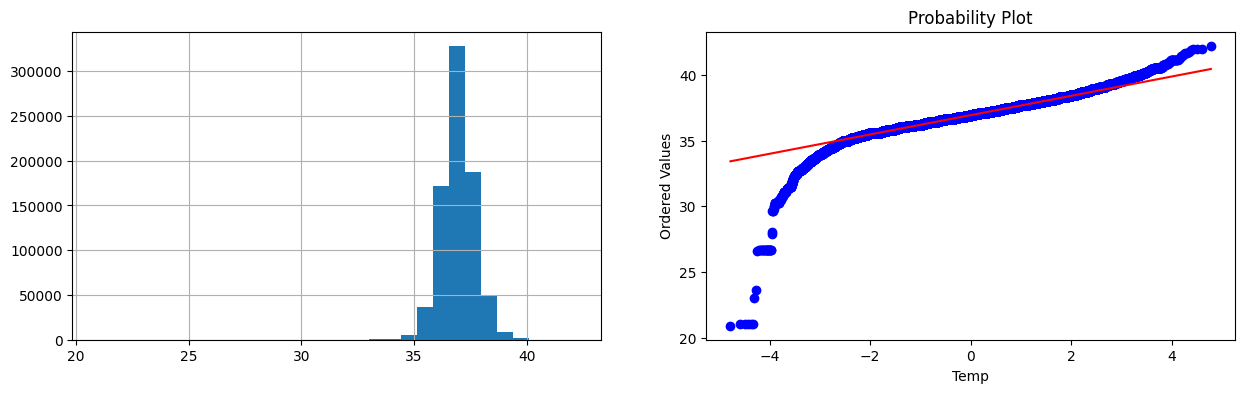

yeojohnson plot


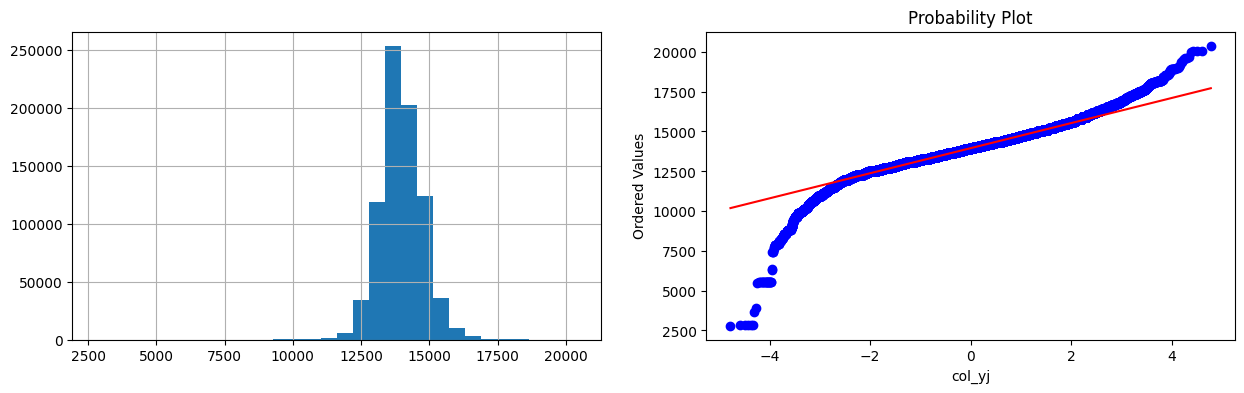

**1/1.5 plot


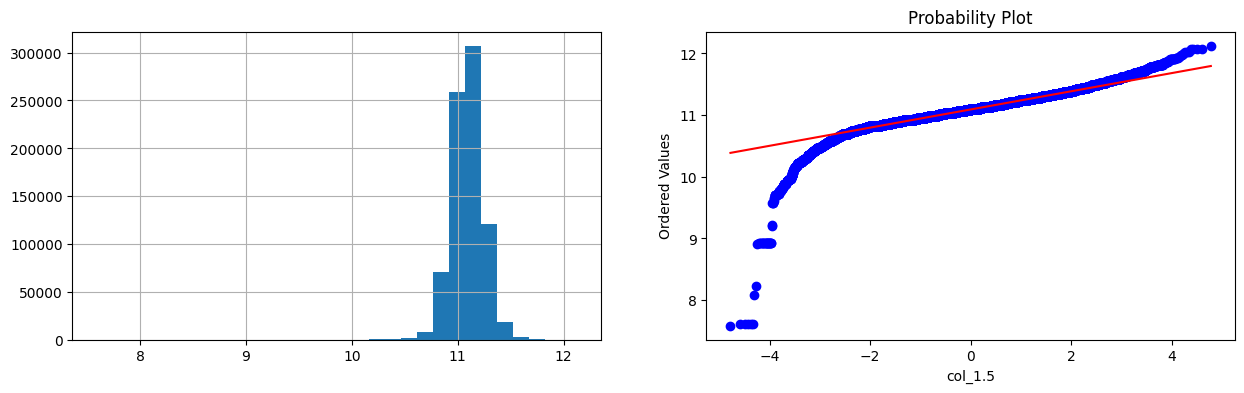

**.5 plot


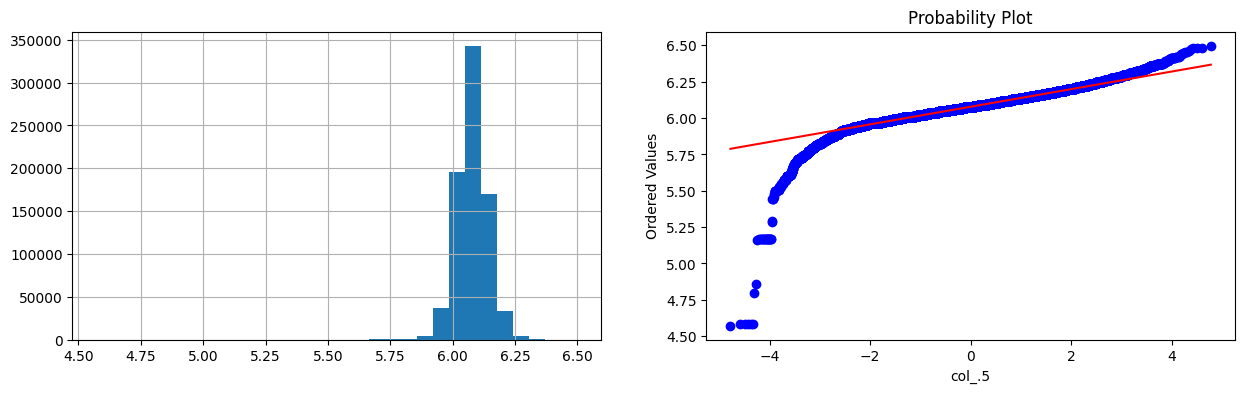

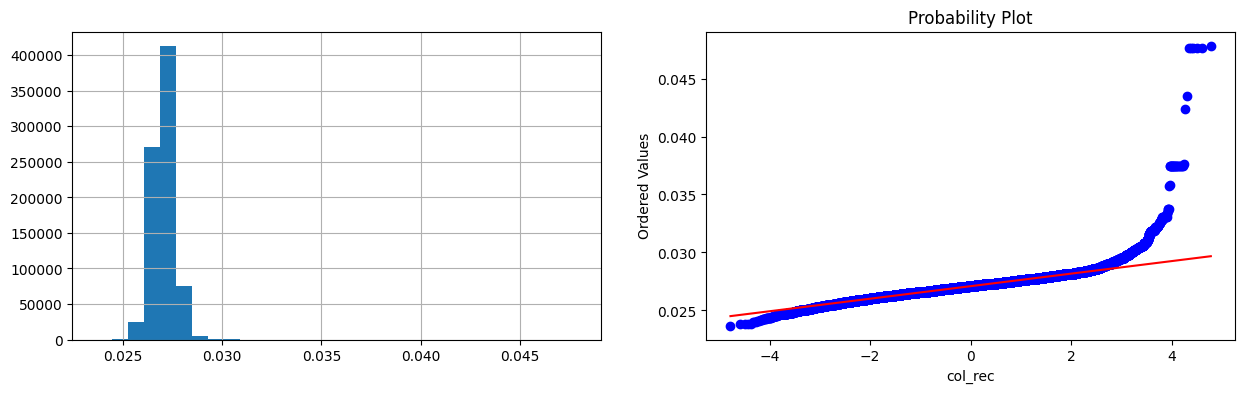

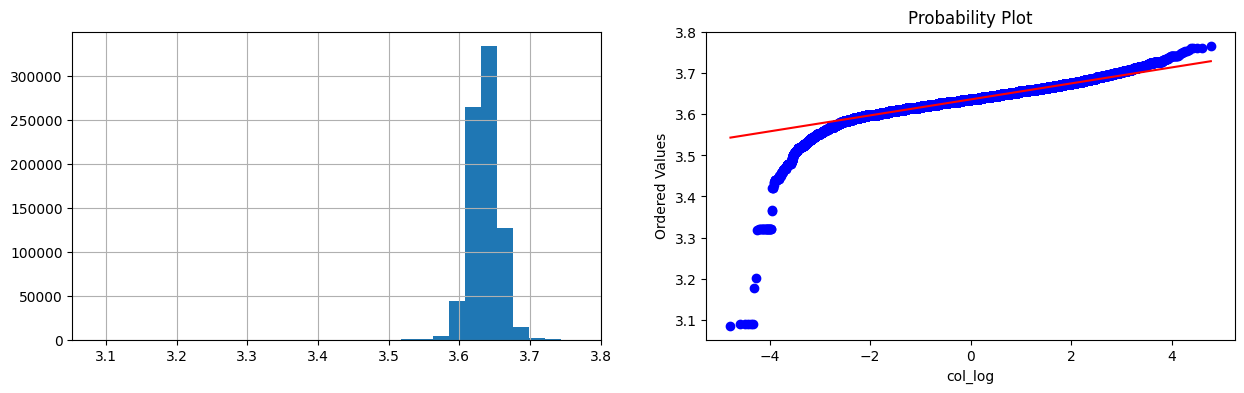

MAP
actual plot


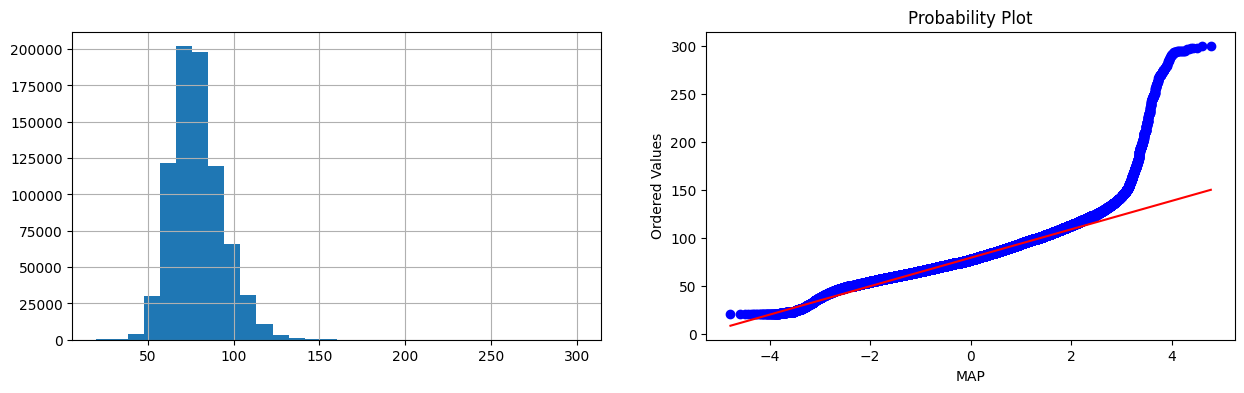

yeojohnson plot


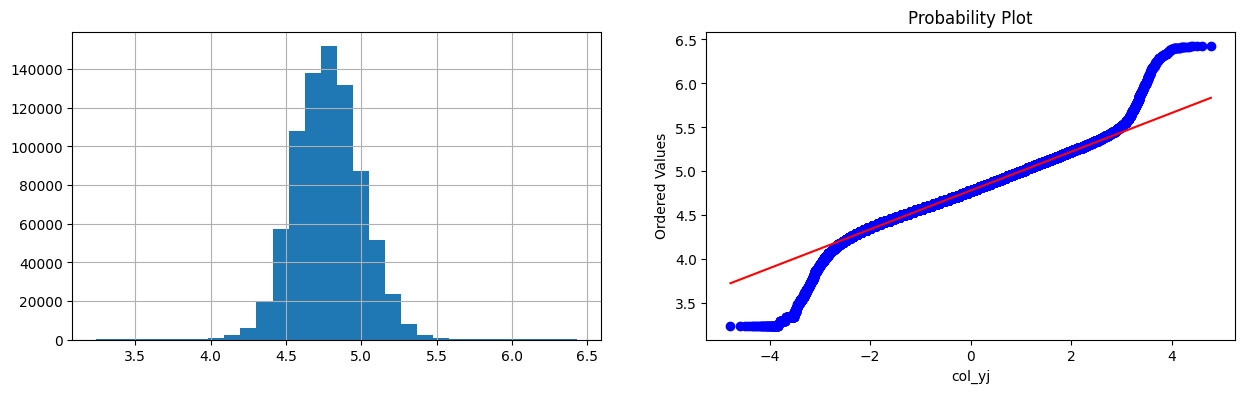

**1/1.5 plot


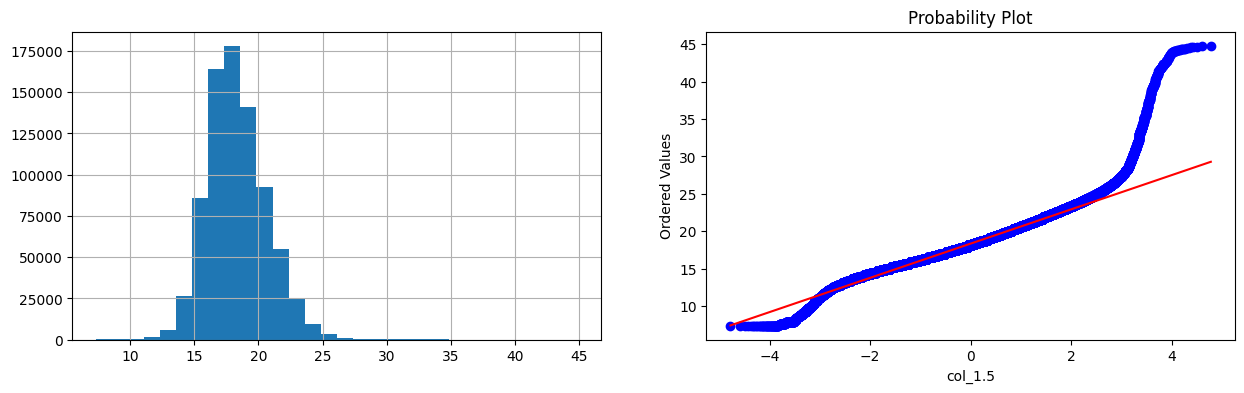

**.5 plot


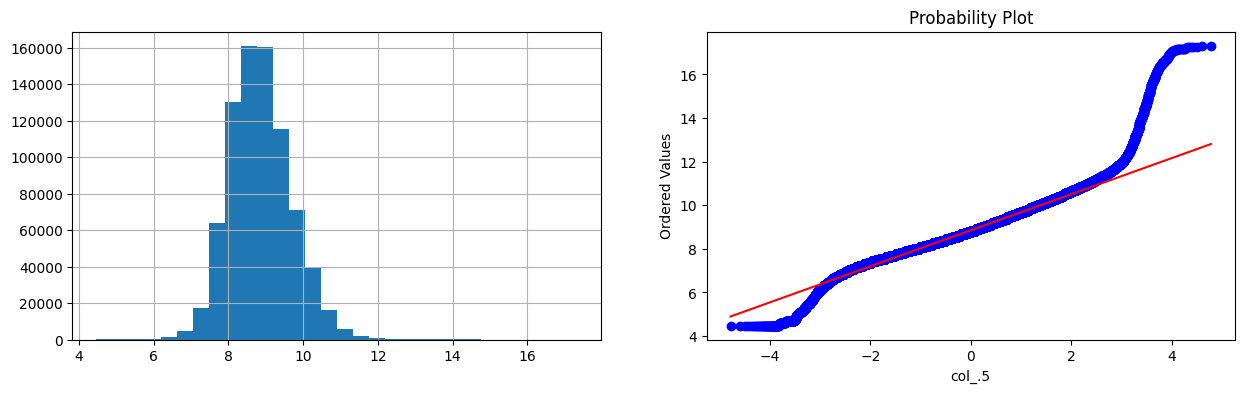

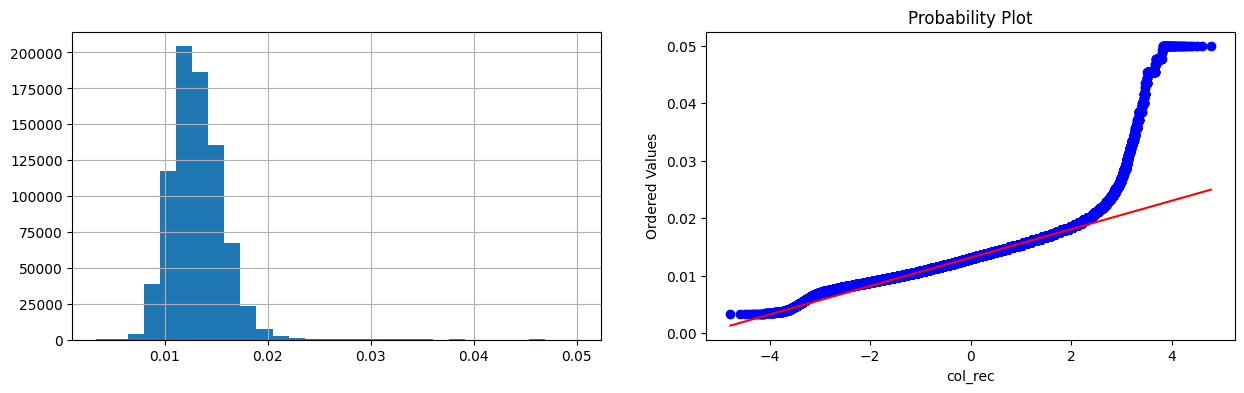

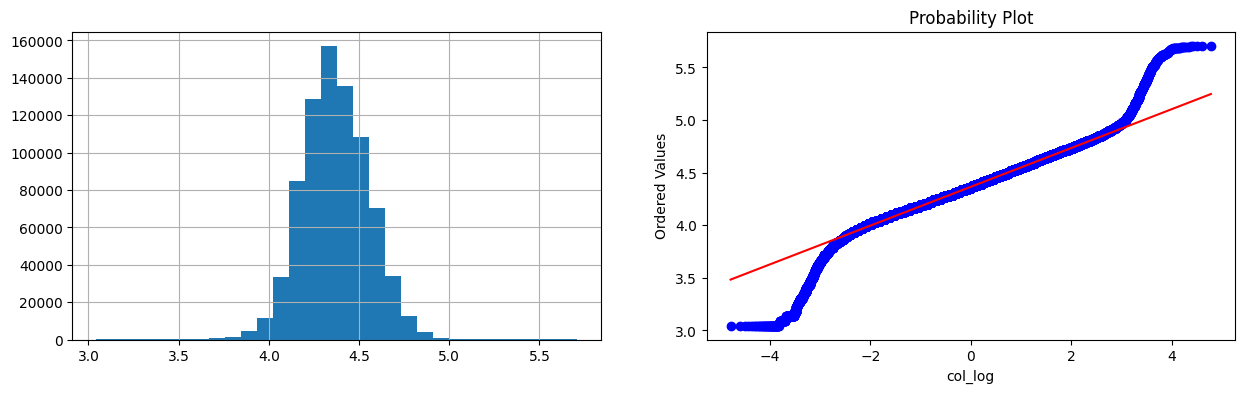

BUN
actual plot


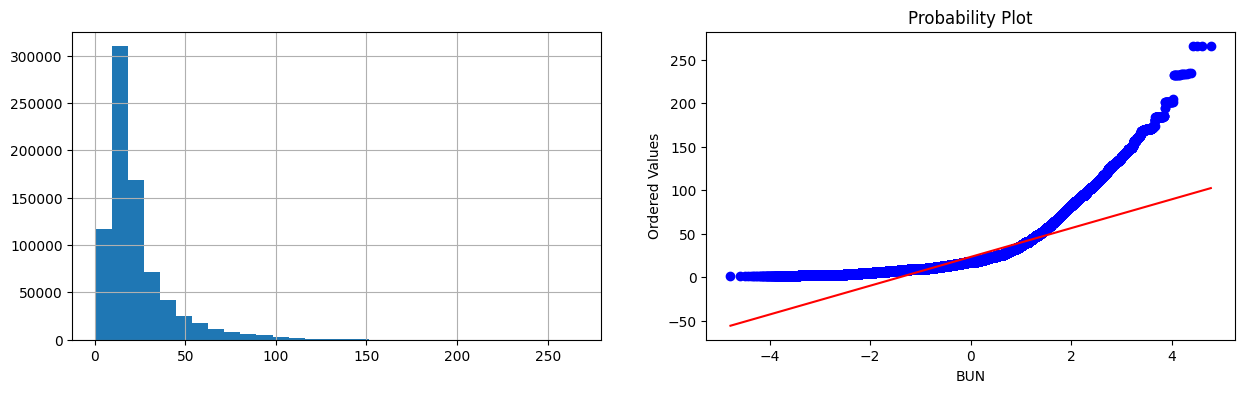

yeojohnson plot


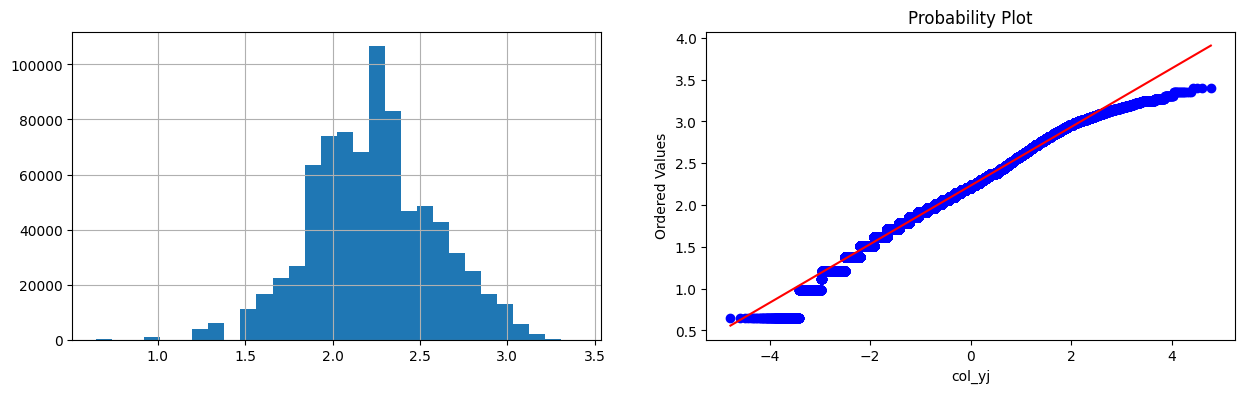

**1/1.5 plot


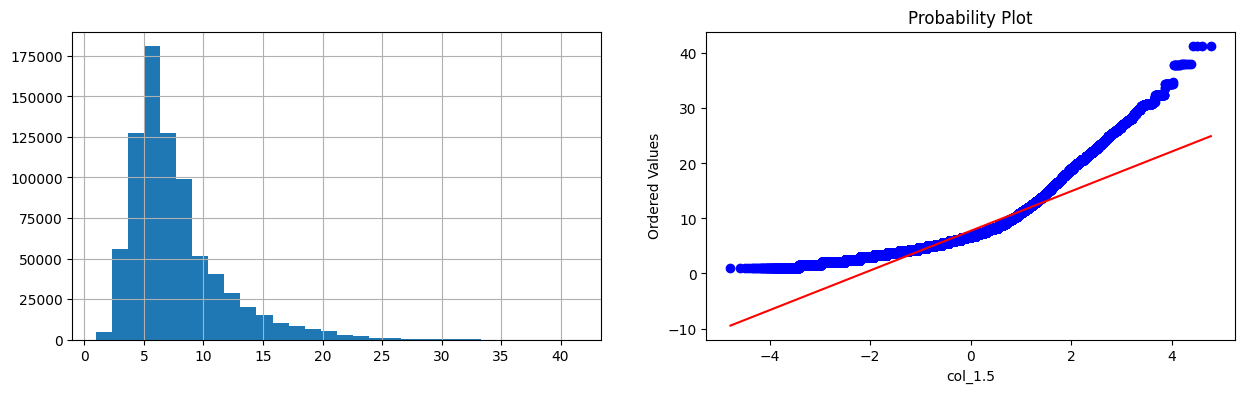

**.5 plot


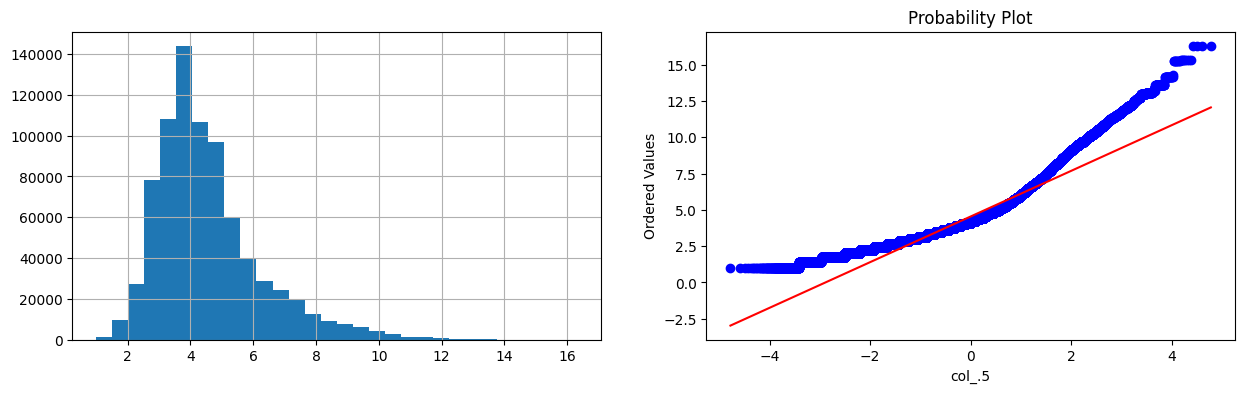

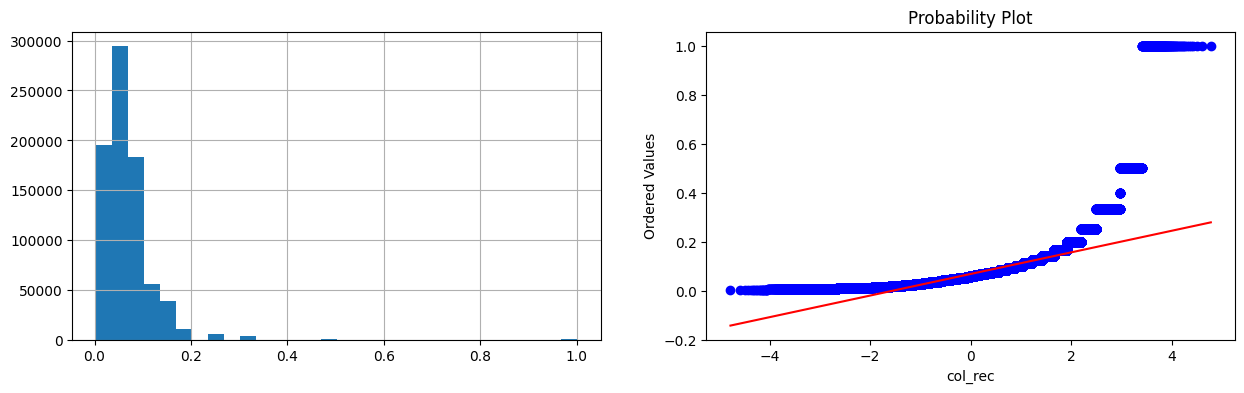

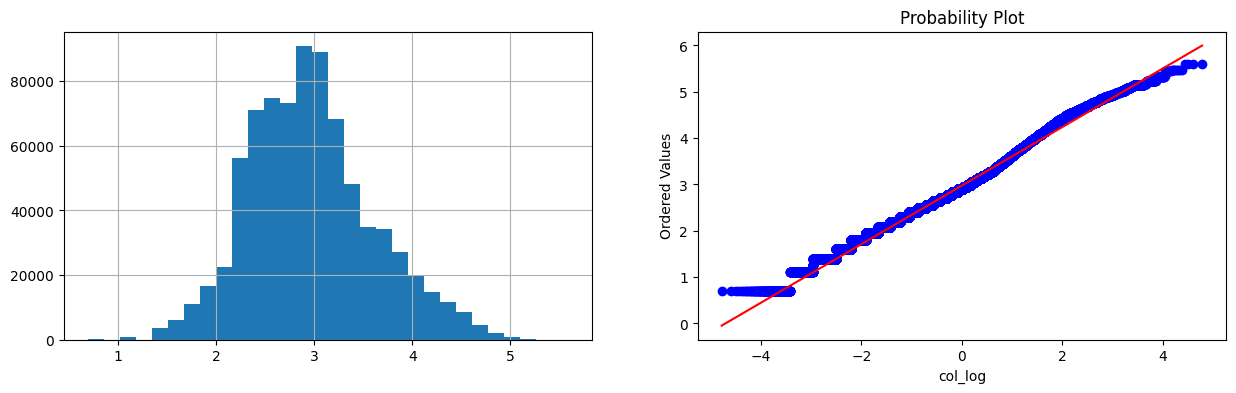

Creatinine
actual plot


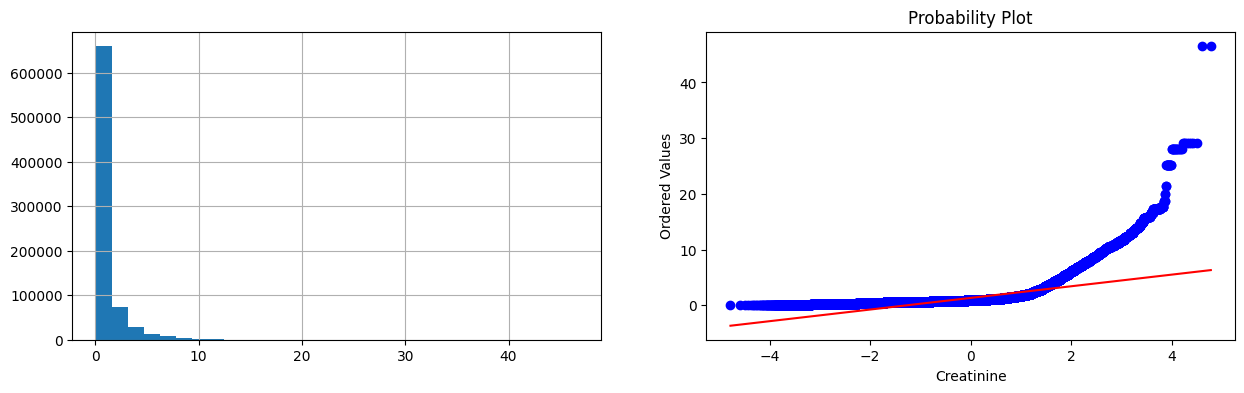

yeojohnson plot


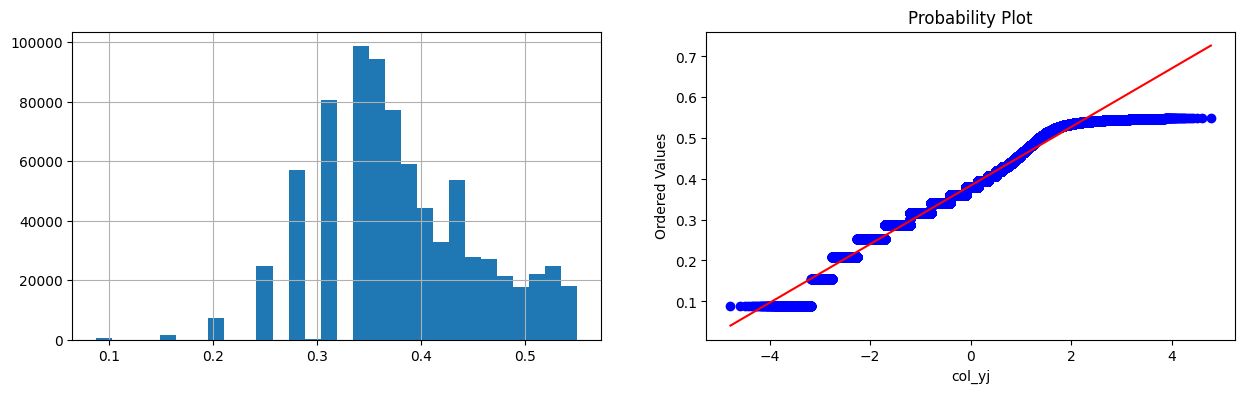

**1/1.5 plot


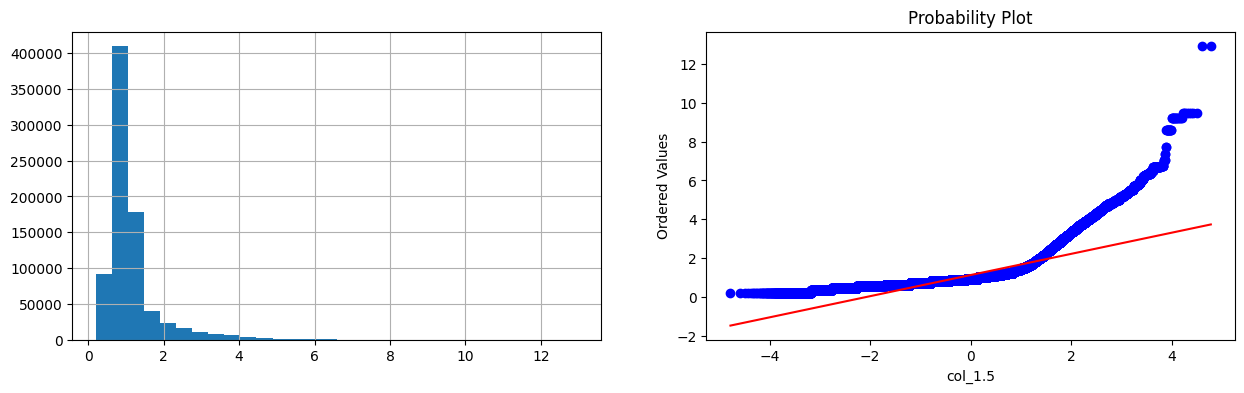

**.5 plot


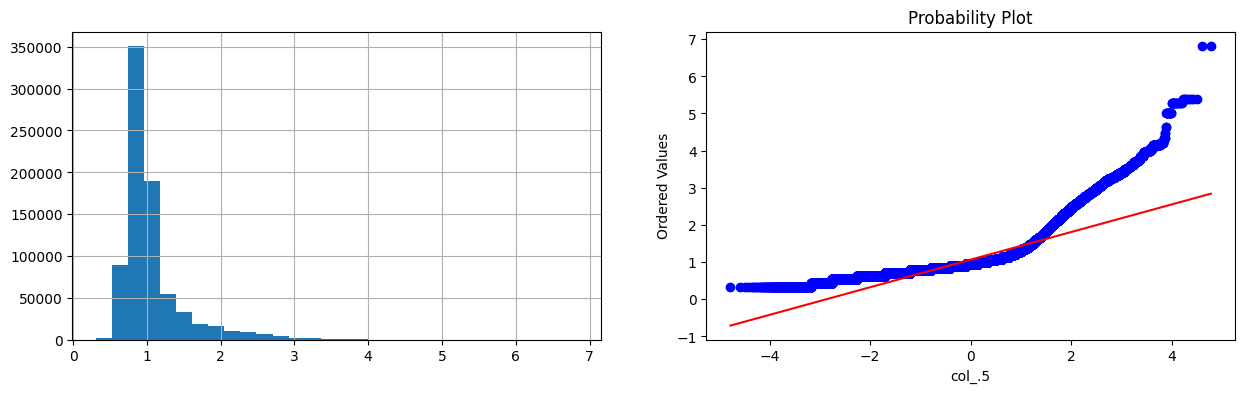

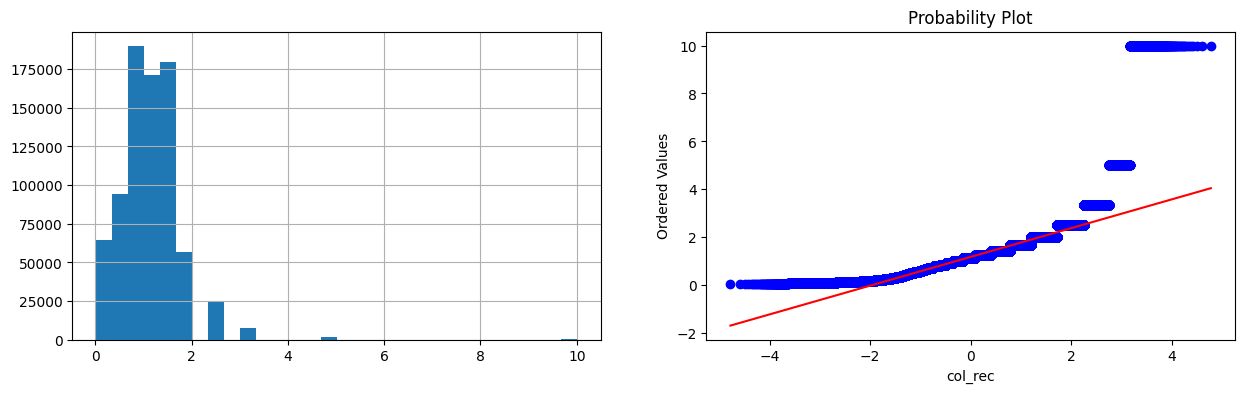

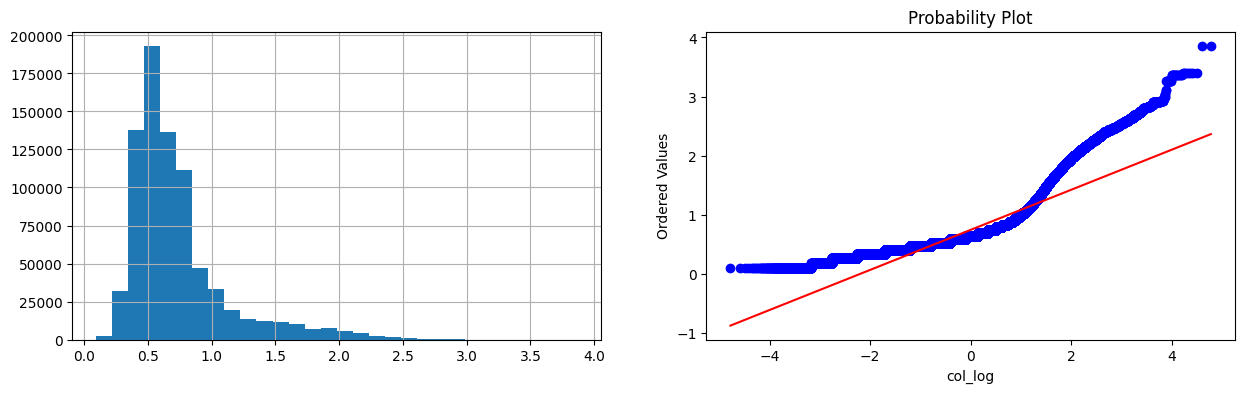

Glucose
actual plot


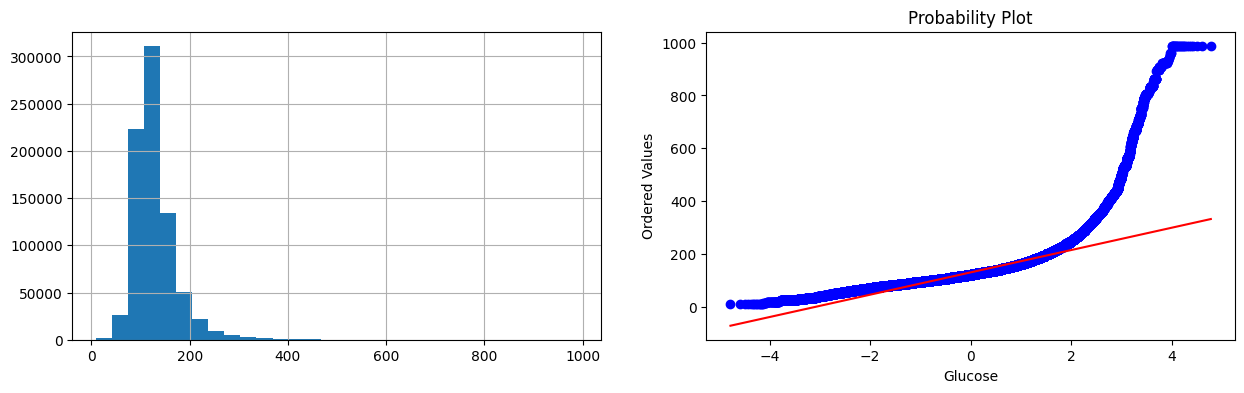

yeojohnson plot


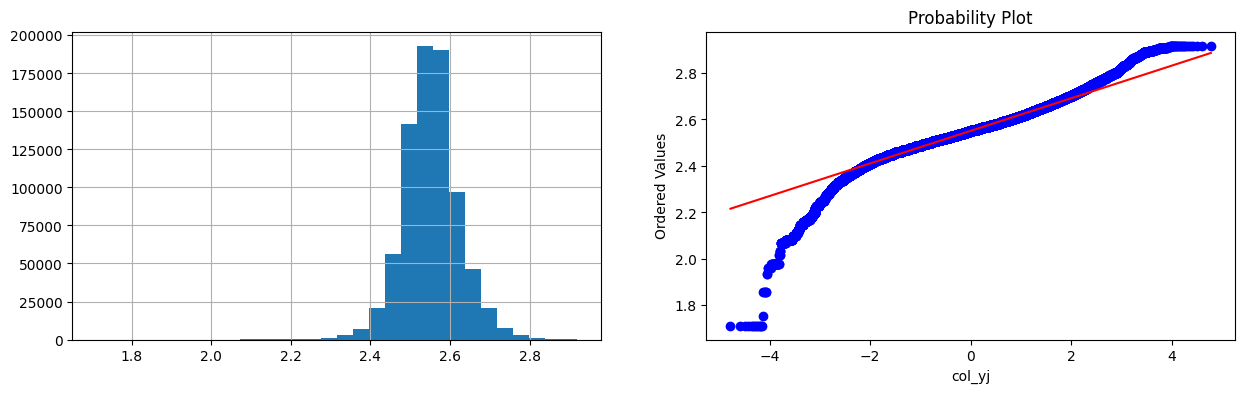

**1/1.5 plot


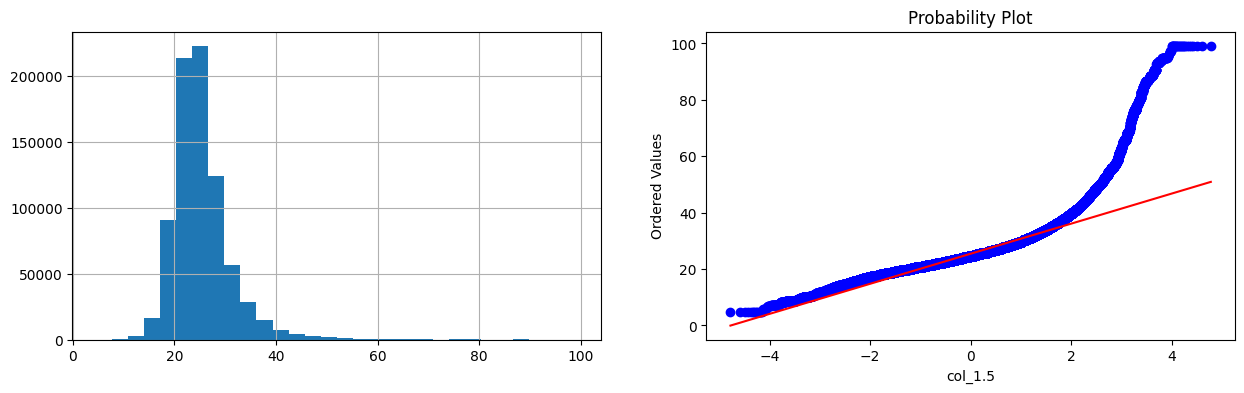

**.5 plot


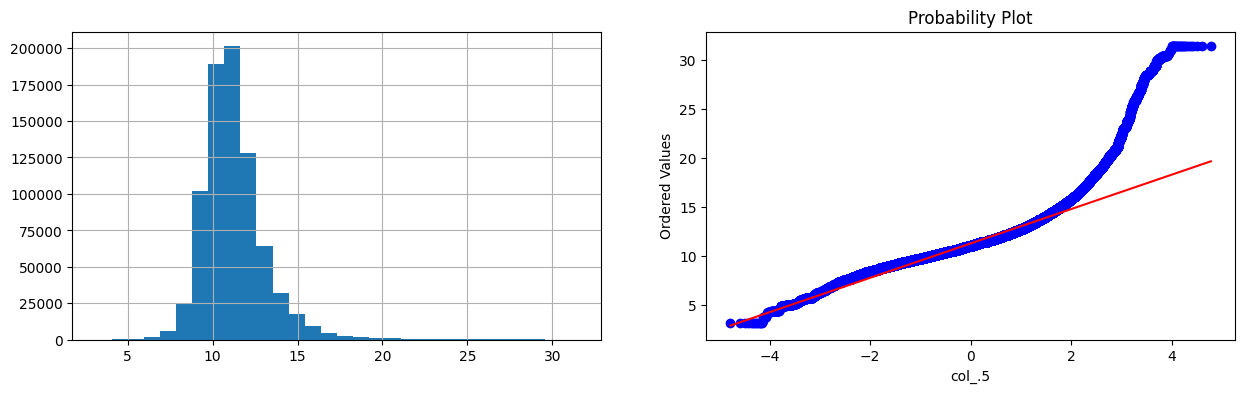

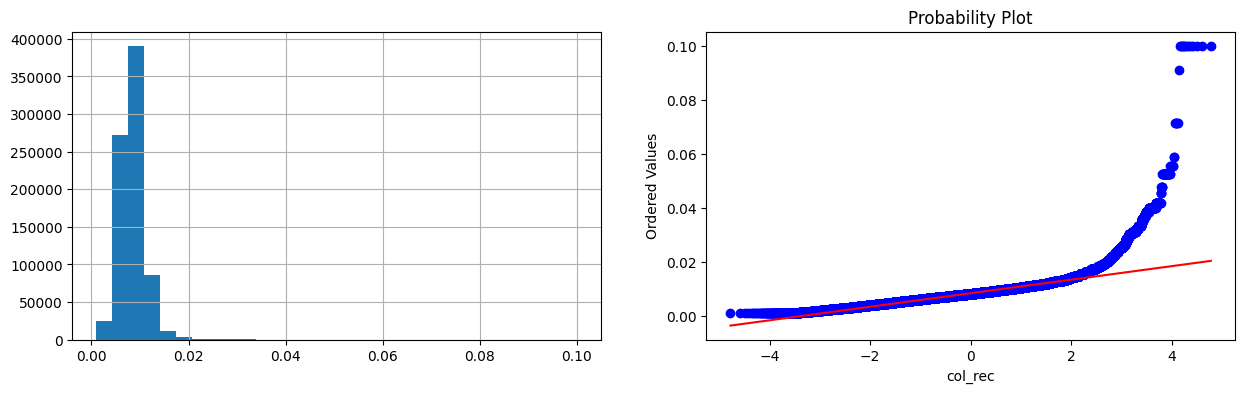

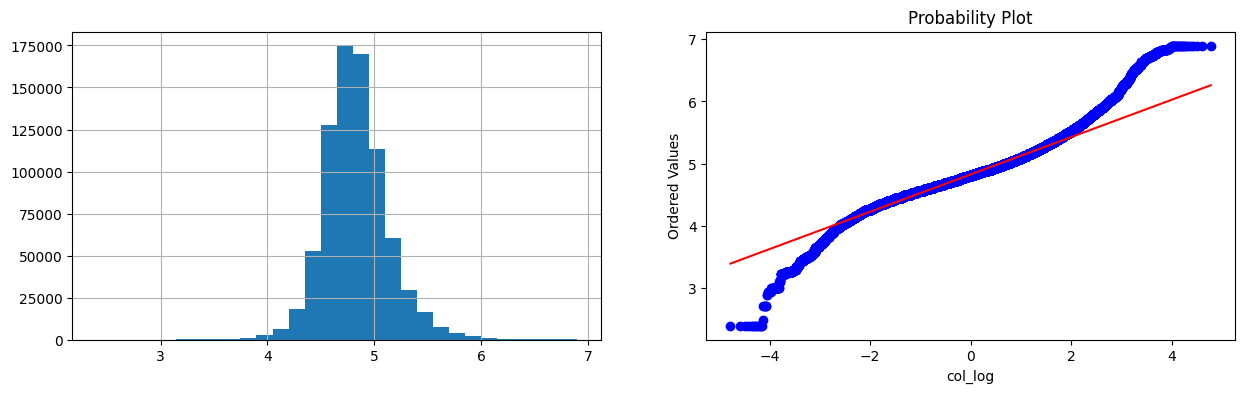

WBC
actual plot


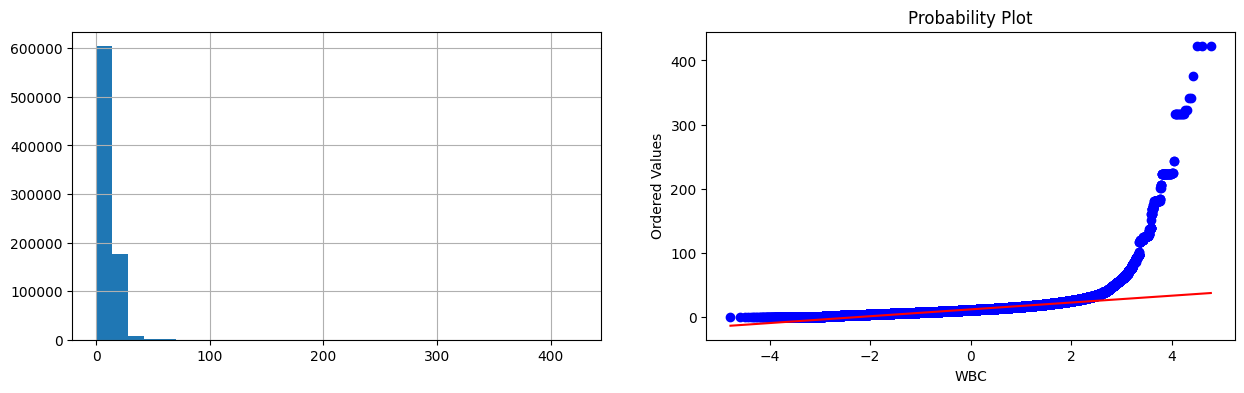

yeojohnson plot


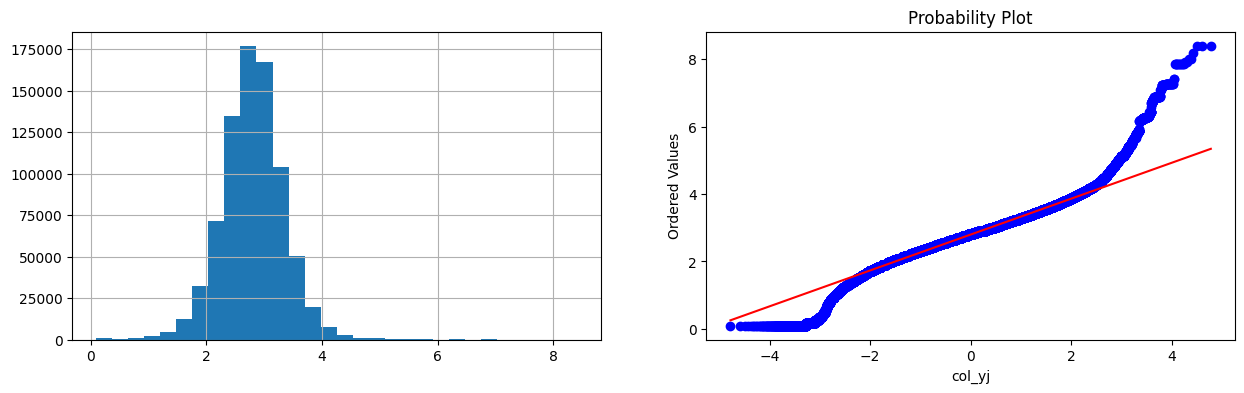

**1/1.5 plot


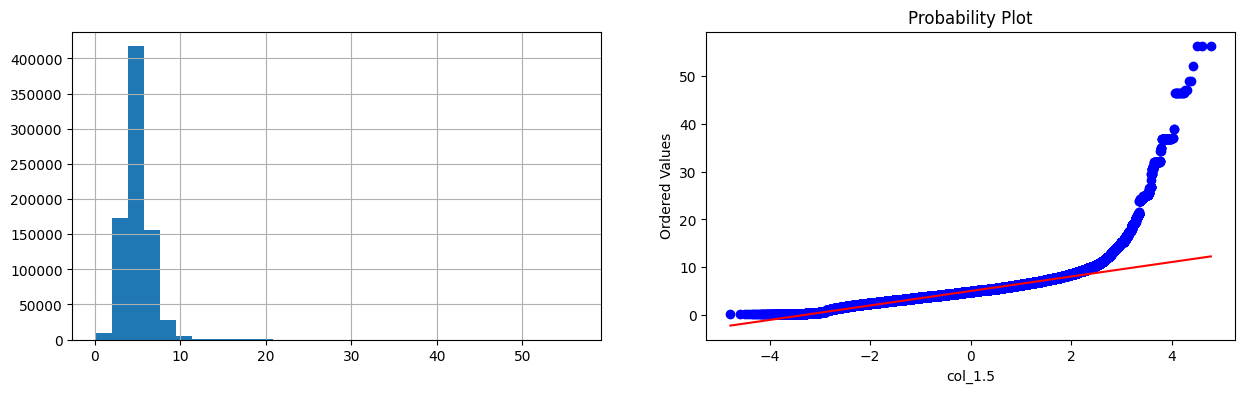

**.5 plot


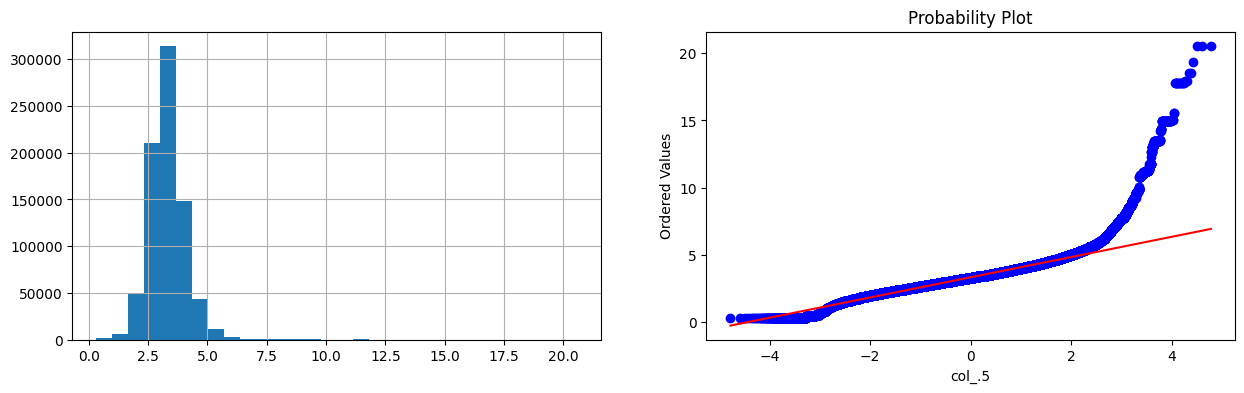

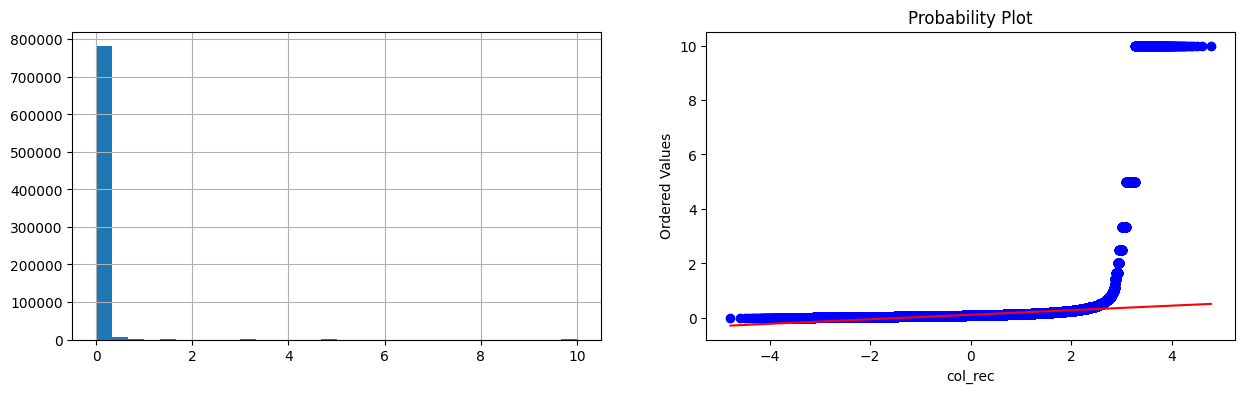

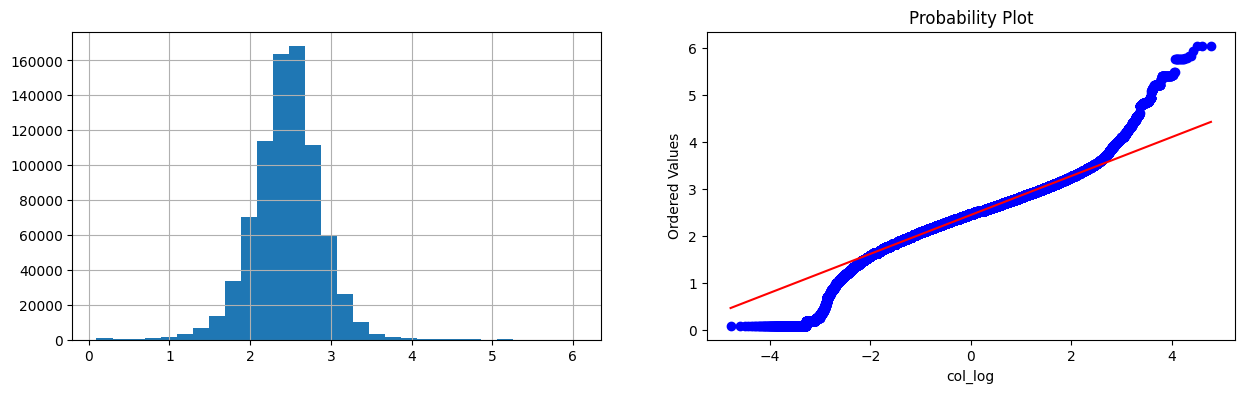

Platelets
actual plot


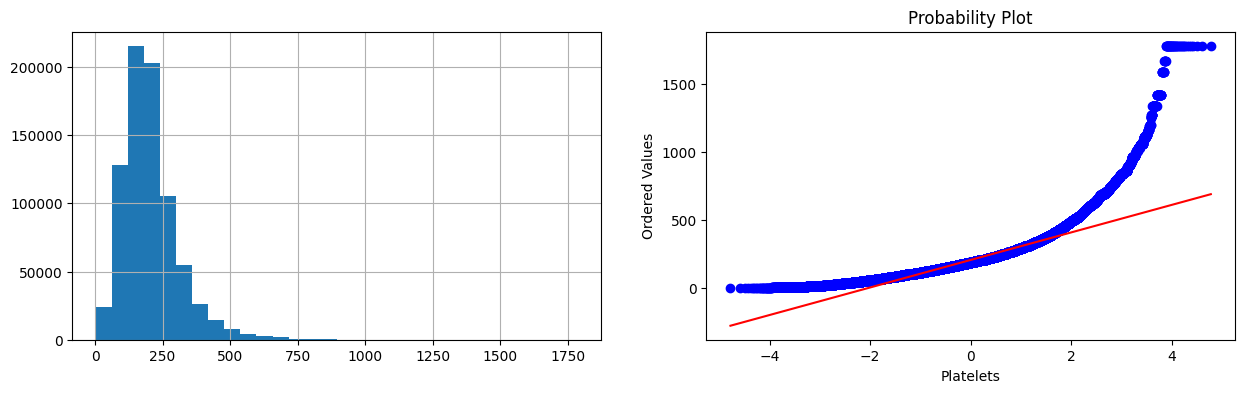

yeojohnson plot


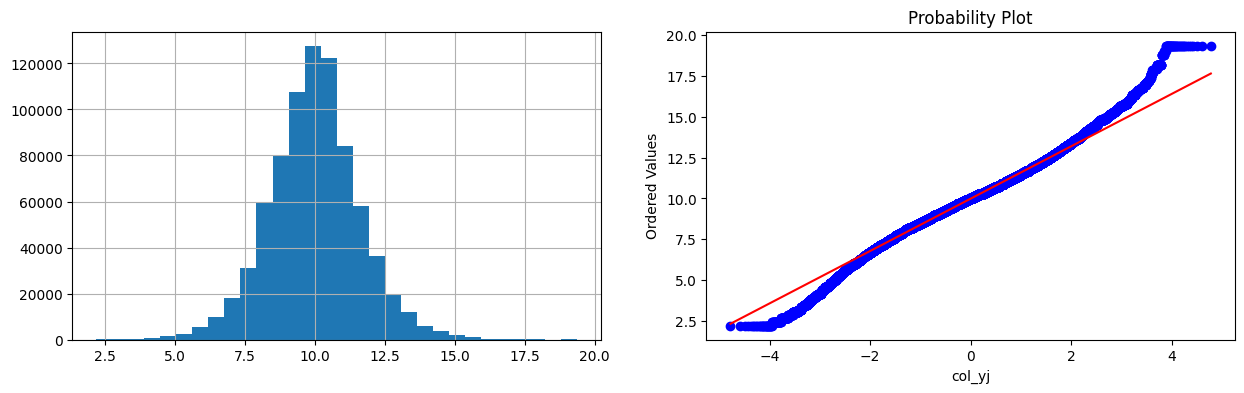

**1/1.5 plot


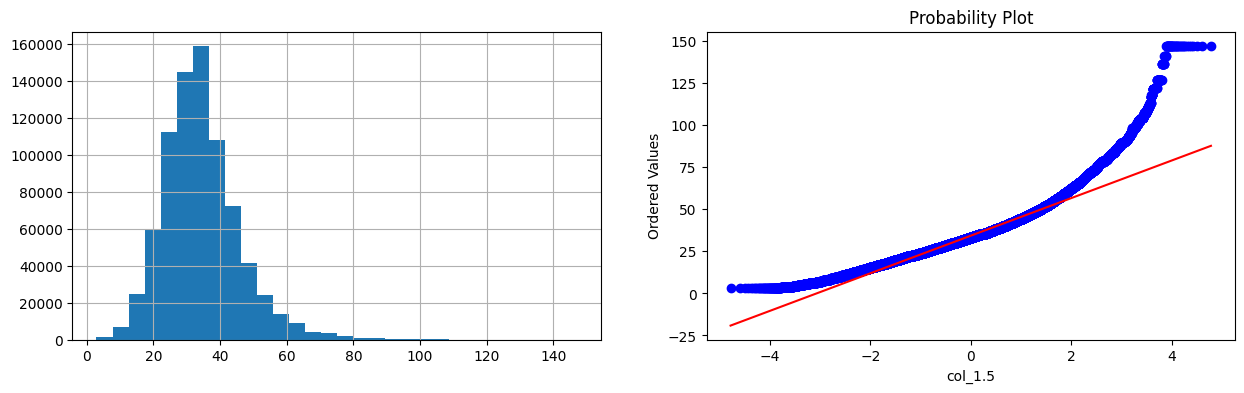

**.5 plot


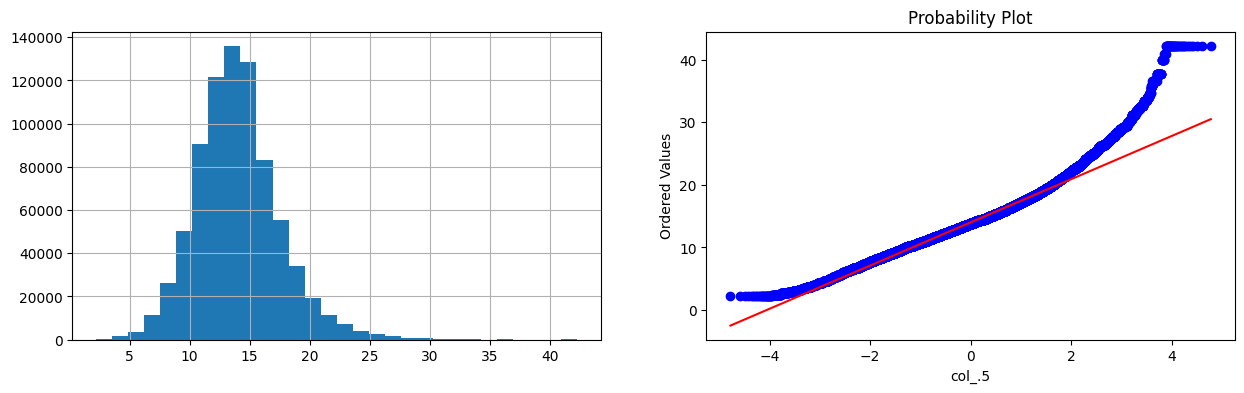

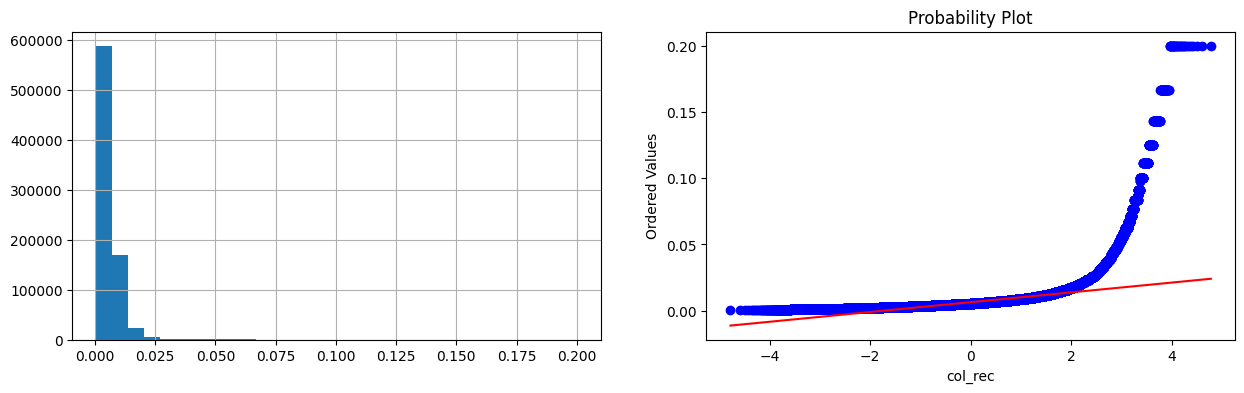

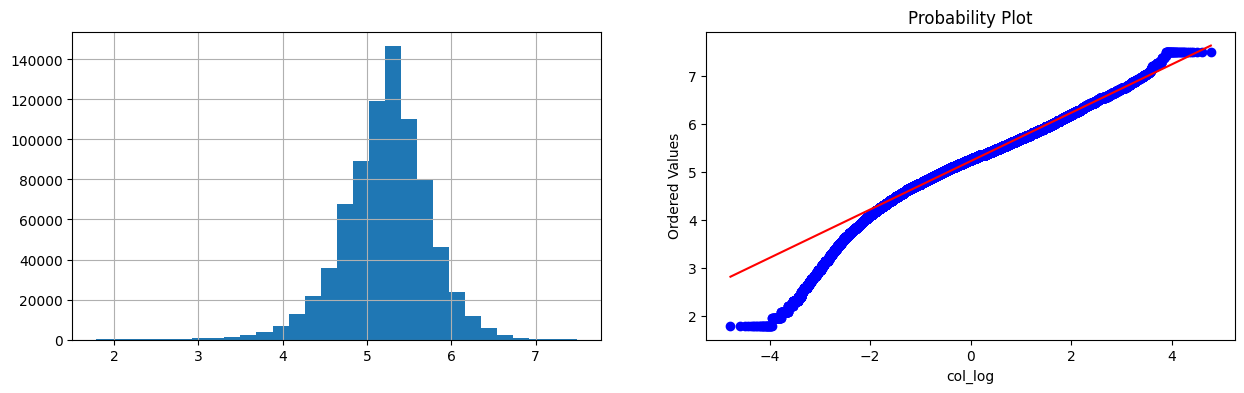

In [ ]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [ ]:
# after application of the above code, some redundant columns got added to the dataframe, which are removed through this line of code
df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [ ]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                  
1          132940     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                   Creatinine  Glucose   Hct   Hgb  WBC  Platelets    Age  \
Patient_ID                                                                  
1          132940         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132941         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132942         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132943         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132944         0.7    193.0  37.2  12.5  5.7      317.0  83.14   

                   HospAdmTime  ICULOS  SepsisLabel     0      1  
Patient_ID                                                        
1          132940        -0.03       1            0  True  False  
           132941        -0.03       2            0  True  False  
           132942        -0.03       3            0  True  False  
           132943        -0.03       4            0  True  False  
           132944        -0.03       5            0  True  False

In [ ]:
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [ ]:
scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132941     1  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132942     2  0.236955  0.555103 -1.110574  0.547993  0.600192   
           132943     3  0.295579 -0.685918 -1.110574  0.868483  2.083649   
           132944     4  1.057696 -2.702577 -1.110574  0.868483  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132941 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132942 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132943 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132944 -0.418013 -3.697098   -0.565677  1.449281  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.301586   1.066178  83.14        -0.03       1   
           132941  1.114903 -1.301586   1.066178  83.14        -0.03       2   
           132942  1.114903 -1.301586   1.066178  83.14        -0.03       3   
           132943  1.114903 -1.301586   1.066178  83.14        -0.03       4   
           132944  1.114903 -1.301586   1.066178  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [ ]:
df_train_impute = df_train_impute.dropna()

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


In [ ]:
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132941     1  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132942     2  0.236955  0.555103 -1.110574  0.547993  0.600192   
           132943     3  0.295579 -0.685918 -1.110574  0.868483  2.083649   
           132944     4  1.057696 -2.702577 -1.110574  0.868483  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132941 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132942 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132943 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132944 -0.418013 -3.697098   -0.565677  1.449281  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.301586   1.066178  83.14        -0.03       1   
           132941  1.114903 -1.301586   1.066178  83.14        -0.03       2   
           132942  1.114903 -1.301586   1.066178  83.14        -0.03       3   
           132943  1.114903 -1.301586   1.066178  83.14        -0.03       4   
           132944  1.114903 -1.301586   1.066178  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [ ]:
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [ ]:
majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15694
while number of sepsis label 0 is 760125


In [ ]:
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

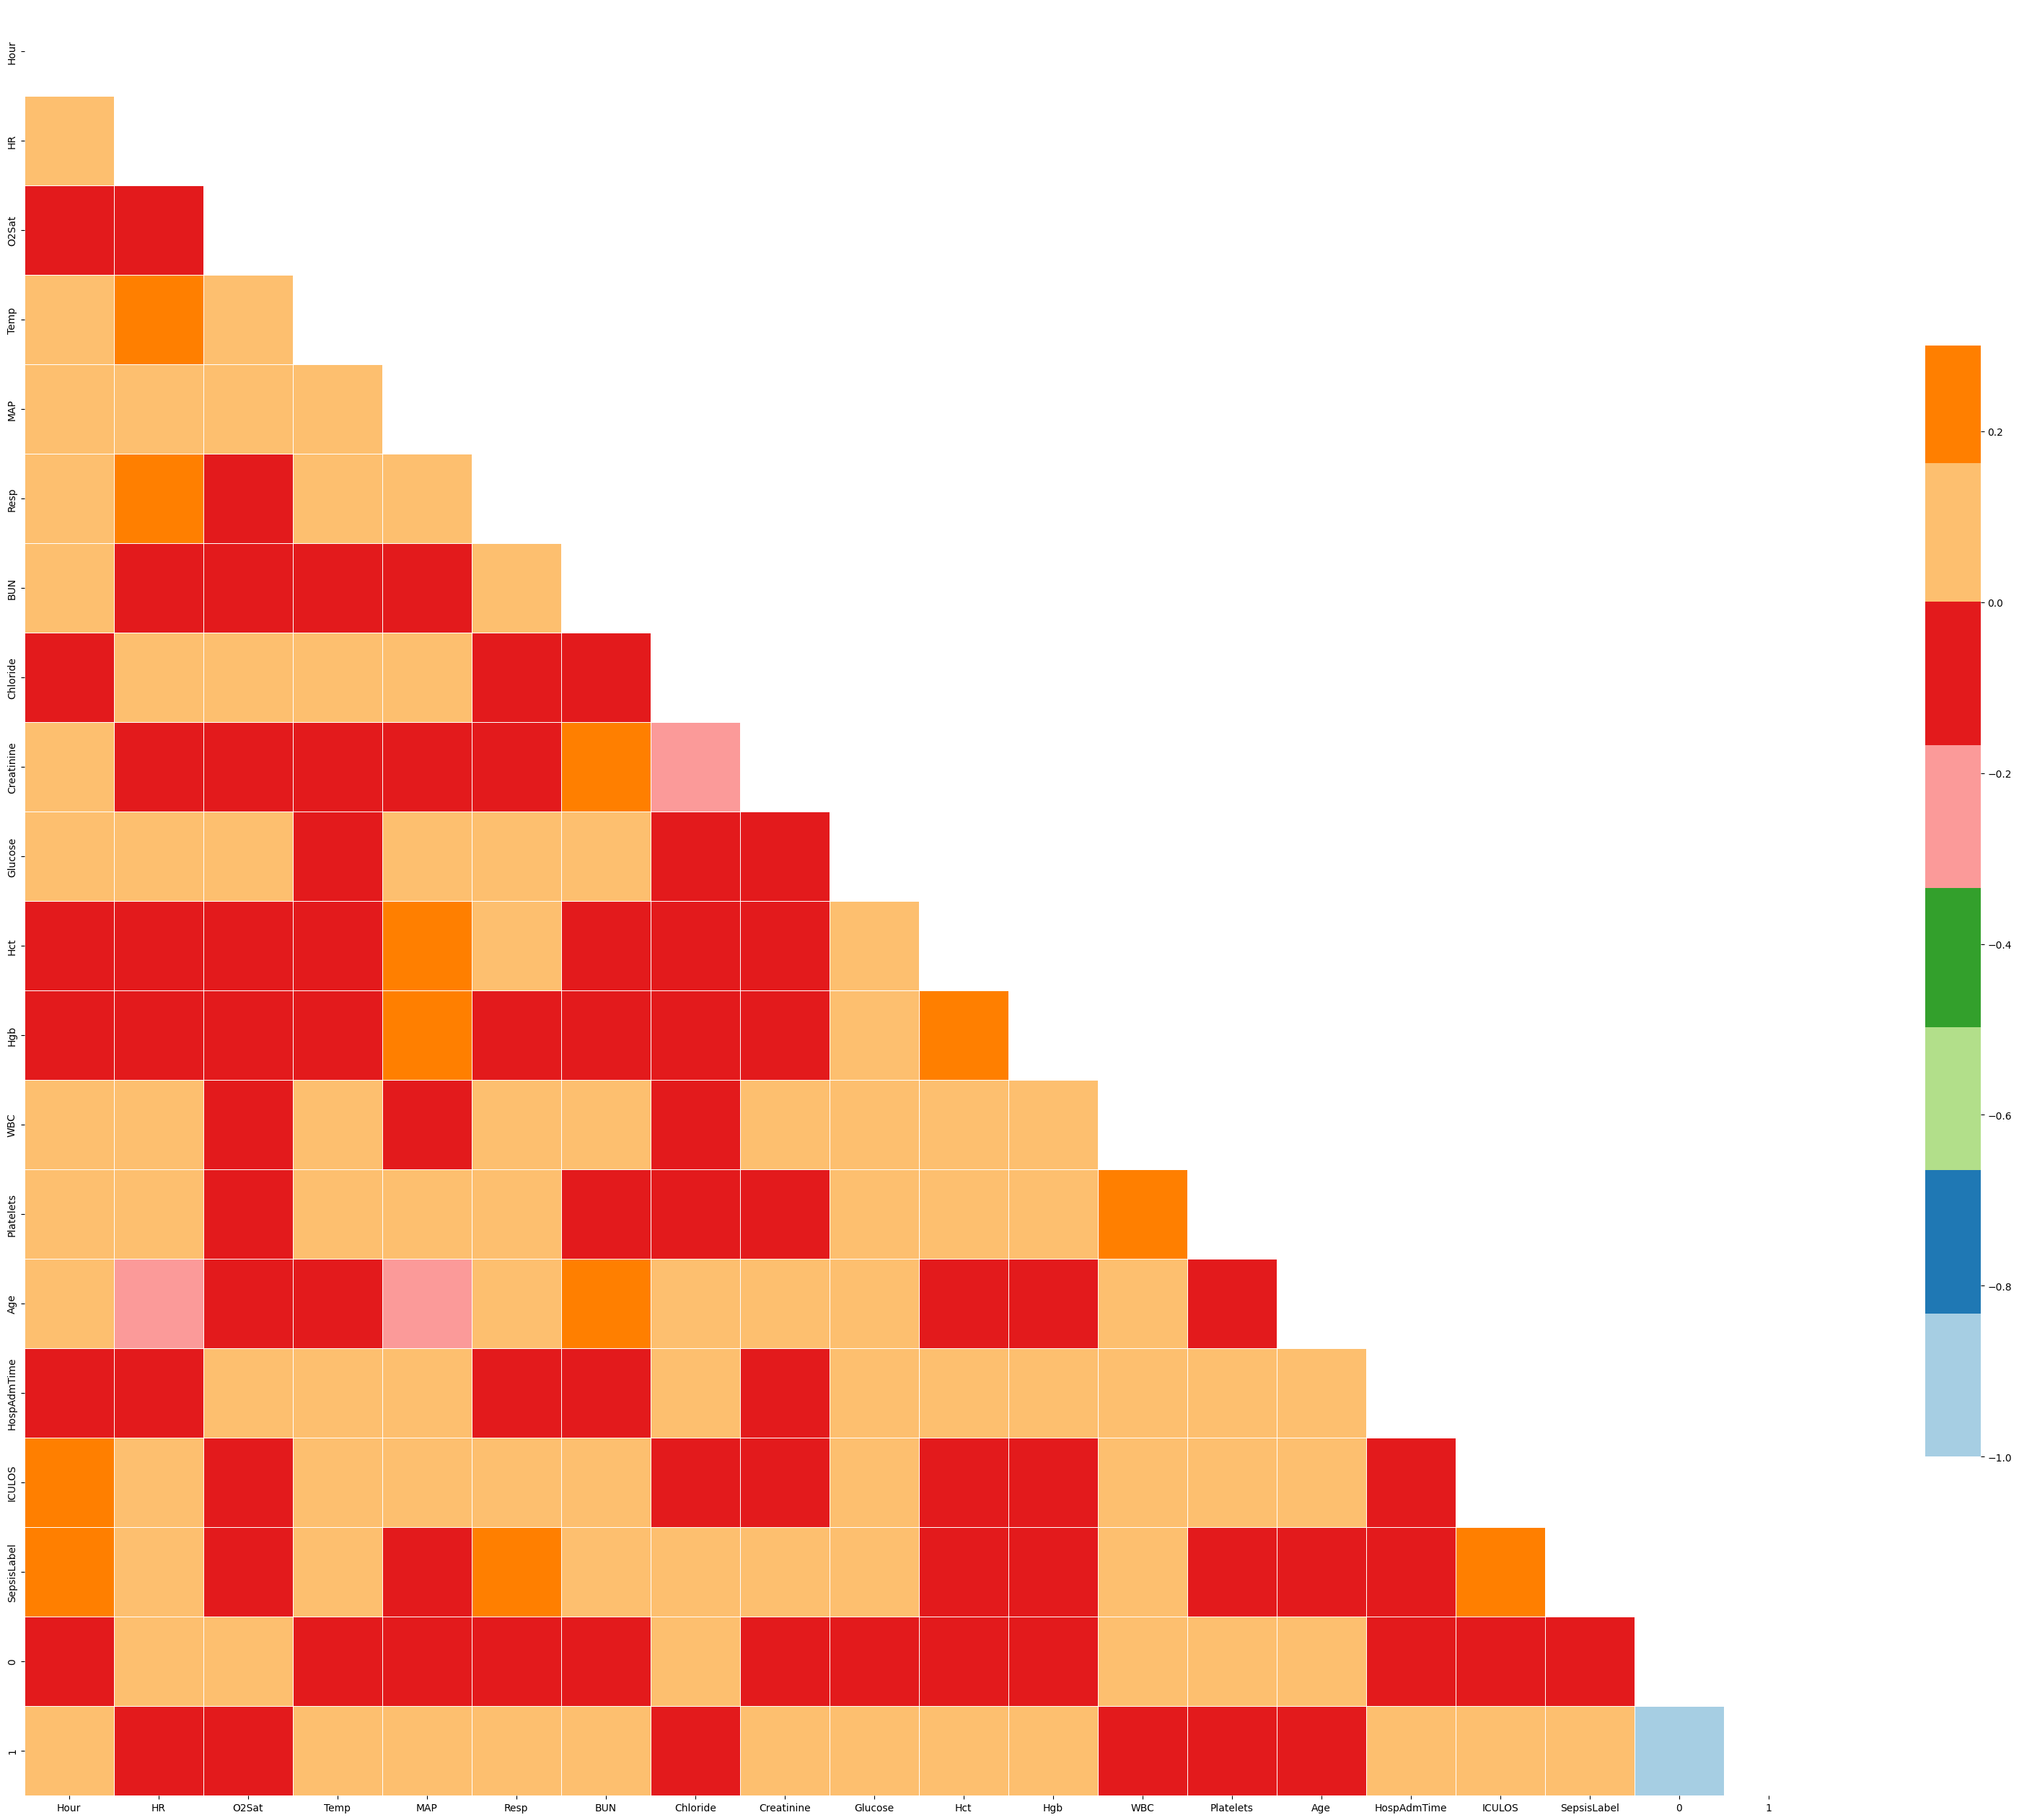

In [ ]:
corr_matrix(df_train_impute)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import RocCurveDisplay

In [ ]:
X = df_train_impute.drop('SepsisLabel', axis=1)
X.columns = X.columns.astype(str)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

In [ ]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  print("Specificity: ", specificity)
  plt.show()
  RocCurveDisplay.from_estimator(model, X_test, y_true)
  plt.title("ROC Curve")
  plt.show()

Accuracy: 0.7468408197939896
Precision: 0.74640522875817
Recall: 0.36392606755895474
F1 Score: 0.4892887746358183
AUC-ROC: 0.6510663941871856
Mean Absolute Error: 0.2531591802060104
Root Mean Squared Error: 0.5031492623526447
Specificity:  0.9382067208154165


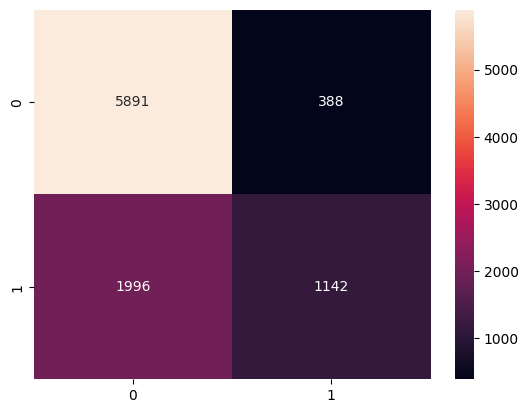

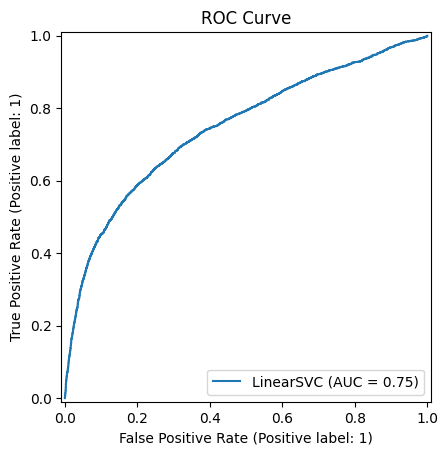

In [ ]:
evaluate_model(y_test,rcf_predictions)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:00:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.858235106721886
Precision: 0.8209327162691349
Recall: 0.7348629700446144
F1 Score: 0.7755170674289558
AUC-ROC: 0.8273773362725064
Mean Absolute Error: 0.14176489327811406
Root Mean Squared Error: 0.37651679016760203
Specificity:  0.9198917025003982


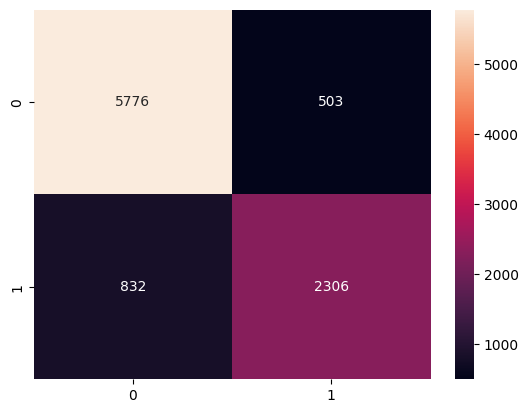

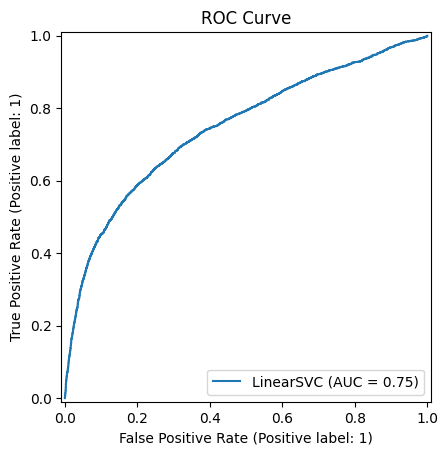

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

Accuracy: 0.7496017840076458
Precision: 0.7363636363636363
Recall: 0.38718929254302104
F1 Score: 0.5075187969924813
AUC-ROC: 0.658955372501802
Mean Absolute Error: 0.25039821599235423
Root Mean Squared Error: 0.5003980575425471
Specificity:  0.9307214524605829


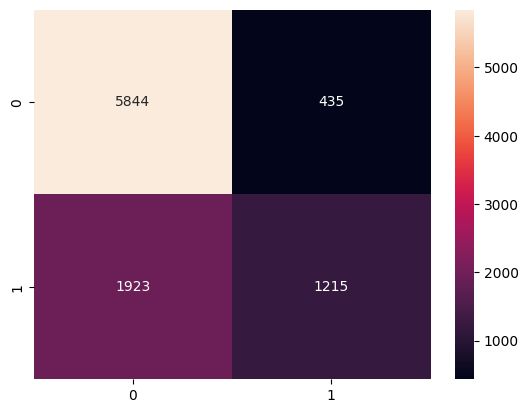

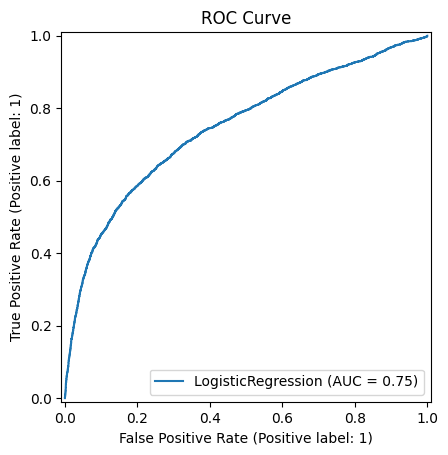

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')  # Adjust `k` for the top features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.7479027291069342
Precision: 0.7016895459345301
Recall: 0.4235181644359465
F1 Score: 0.5282193958664547
AUC-ROC: 0.6667678415745588
Mean Absolute Error: 0.2520972708930657
Root Mean Squared Error: 0.5020928907015769
Specificity:  0.9100175187131709


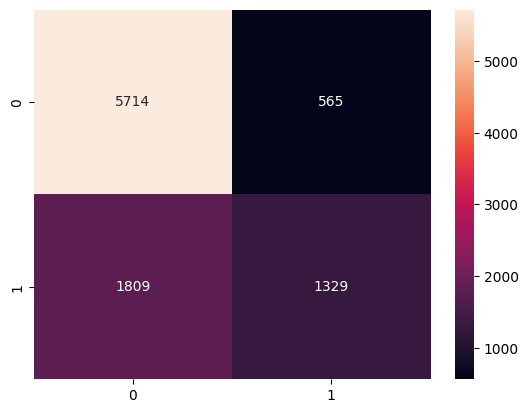

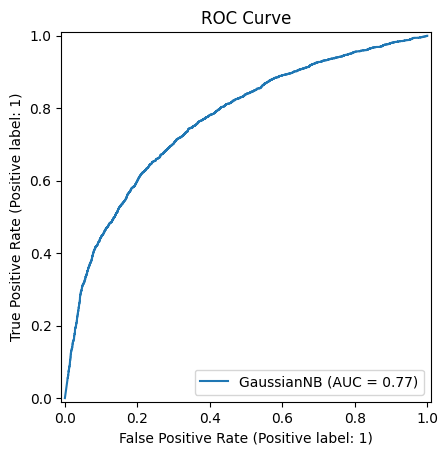

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.7468408197939896
Precision: 0.74640522875817
Recall: 0.36392606755895474
F1 Score: 0.4892887746358183
AUC-ROC: 0.6510663941871856
Mean Absolute Error: 0.2531591802060104
Root Mean Squared Error: 0.5031492623526447
Specificity:  0.9382067208154165


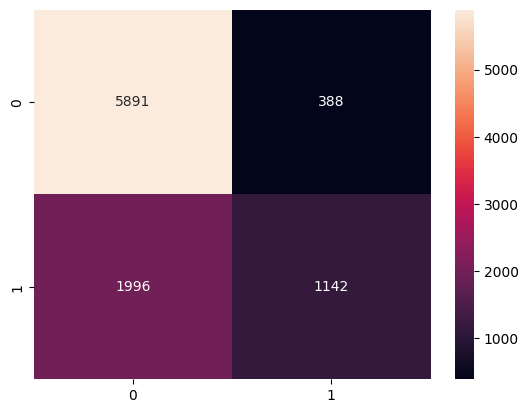

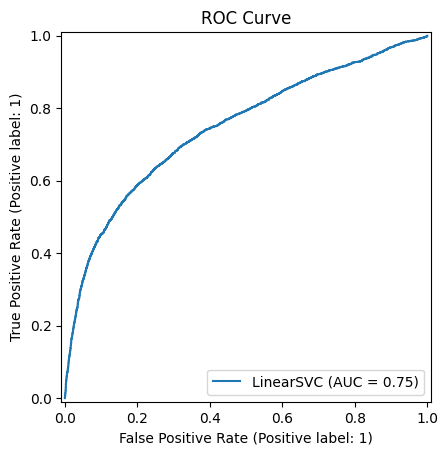

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)
evaluate_model(y_test,rcf_predictions)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model


In [ ]:
input_shape = X_train.shape[1]

In [ ]:
model = create_model(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,  # Increase epochs for more training
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6514 - auc: 0.6524 - loss: 0.6456 - val_accuracy: 0.7645 - val_auc: 0.7916 - val_loss: 0.5079
Epoch 2/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7467 - auc: 0.7644 - loss: 0.5328 - val_accuracy: 0.7704 - val_auc: 0.8057 - val_loss: 0.4940
Epoch 3/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7552 - auc: 0.7858 - loss: 0.5157 - val_accuracy: 0.7752 - val_auc: 0.8166 - val_loss: 0.4842
Epoch 4/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7606 - auc: 0.7923 - loss: 0.5088 - val_accuracy: 0.7775 - val_auc: 0.8222 - val_loss: 0.4775
Epoch 5/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7679 - auc: 0.8015 - loss: 0.4956 - val_accuracy: 0.7829 - val_auc: 0.8267 - val_loss: 0.4765
Epoch 6/100
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7711 - auc: 0.8085 - loss: 0.4921 - val_accuracy: 0.7823 - val_auc: 0.8306 - val_loss: 0.4695
Epoch 7/100
1178/117

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}")


295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8616 - auc: 0.9201 - loss: 0.3444
Test Loss: 0.3453758955001831, Test Accuracy: 0.8590846061706543, Test AUC: 0.9201498627662659


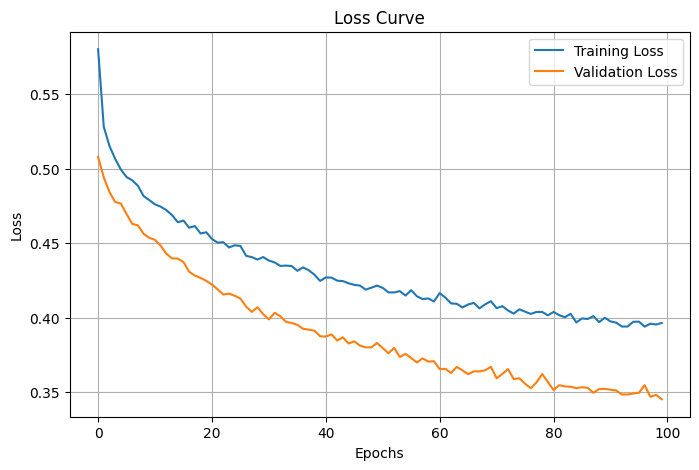

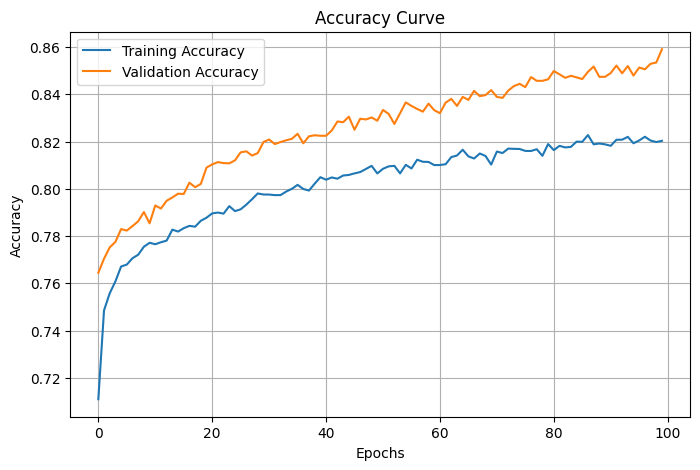

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Specify the path in your Google Drive where you want to save the model
model_path = '/content/drive/MyDrive/sepsis_prediction_model.h5'

# Save the model to the specified path
model.save(model_path)


In [ ]:
from tensorflow.keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/sepsis_prediction_model.h5'

model = load_model(model_path)
